# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans
from sklearn import preprocessing
from sklearn.decomposition import PCA    
# magic word for producing visualizations in notebook
%matplotlib inline

print('''
Import note: The classroom currently uses sklearn version 0.19.
If you need to use an imputer, it is available in sklearn.preprocessing.Imputer,
instead of sklearn.impute as in newer versions of sklearn.
''')


Import note: The classroom currently uses sklearn version 0.19.
If you need to use an imputer, it is available in sklearn.preprocessing.Imputer,
instead of sklearn.impute as in newer versions of sklearn.



### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [2]:
# Load in the general demographics data.
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv', sep=';')
# Load in the feature summary file.
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', sep = ';')

In [3]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).
print('Shape of general demographics data is:\n\t',azdias.shape)
azdias.head(6)

Shape of general demographics data is:
	 (891221, 85)


AGER_TYP  ALTERSKATEGORIE_GROB  ANREDE_KZ  CJT_GESAMTTYP  \
0        -1                     2          1            2.0   
1        -1                     1          2            5.0   
2        -1                     3          2            3.0   
3         2                     4          2            2.0   
4        -1                     3          1            5.0   
5         3                     1          2            2.0   

   FINANZ_MINIMALIST  FINANZ_SPARER  FINANZ_VORSORGER  FINANZ_ANLEGER  \
0                  3              4                 3               5   
1                  1              5                 2               5   
2                  1              4                 1               2   
3                  4              2                 5               2   
4                  4              3                 4               1   
5                  3              1                 5               2   

   FINANZ_UNAUFFAELLIGER  FINANZ_HAUSBAUER  ...  PLZ8_ANTG1  PLZ8_ANTG2  \
0                      5                 3  ...         NaN         NaN   
1                      4                 5  ...         2.0         3.0   
2                      3                 5  ...         3.0         3.0   
3                      1                 2  ...         2.0         2.0   
4                      3                 2  ...         2.0         4.0   
5                      2                 5  ...         2.0         3.0   

   PLZ8_ANTG3  PLZ8_ANTG4  PLZ8_BAUMAX  PLZ8_HHZ  PLZ8_GBZ  ARBEIT  \
0         NaN         NaN          NaN       NaN       NaN     NaN   
1         2.0         1.0          1.0       5.0       4.0     3.0   
2         1.0         0.0          1.0       4.0       4.0     3.0   
3         2.0         0.0          1.0       3.0       4.0     2.0   
4         2.0         1.0          2.0       3.0       3.0     4.0   
5         1.0         1.0          1.0       5.0       5.0     2.0   

   ORTSGR_KLS9  RELAT_AB  
0          NaN       NaN  
1          5.0       4.0  
2          5.0       2.0  
3          3.0       3.0  
4          6.0       5.0  
5          3.0       3.0  

[6 rows x 85 columns]

In [4]:
print('Shape of feature summary file data is:\n\t',feat_info.shape)
feat_info.values[:,3]

Shape of feature summary file data is:
	 (85, 4)


array(['[-1,0]', '[-1,0,9]', '[-1,0]', '[0]', '[-1]', '[-1]', '[-1]',
       '[-1]', '[-1]', '[-1]', '[-1]', '[0]', '[]', '[]', '[-1,0]', '[0]',
       '[0]', '[0]', '[0]', '[0]', '[0]', '[-1,0]', '[-1,0]', '[0]',
       '[-1,9]', '[-1,9]', '[-1,9]', '[-1,9]', '[-1,9]', '[-1,9]',
       '[-1,9]', '[-1,9]', '[-1,9]', '[-1,9]', '[-1,9]', '[-1,9]',
       '[-1,9]', '[-1,9]', '[-1]', '[-1]', '[-1,0]', '[-1]', '[-1,9]',
       '[0]', '[]', '[]', '[-1,0]', '[-1]', '[-1,0]', '[-1,0]', '[0]',
       '[]', '[-1,0]', '[]', '[0]', '[-1]', '[-1]', '[-1,X]', '[XX]',
       '[-1,XX]', '[-1]', '[-1]', '[-1]', '[-1]', '[-1,0]', '[-1,0]',
       '[-1]', '[-1]', '[-1]', '[]', '[-1,0]', '[]', '[]', '[-1,0]', '[]',
       '[-1]', '[-1]', '[-1]', '[-1]', '[-1,0]', '[-1]', '[-1]', '[-1,9]',
       '[-1,0]', '[-1,9]'], dtype=object)

> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [5]:
# Identify missing or unknown data values and convert them to NaNs.
array2d_nan_count = azdias.isnull().to_numpy(dtype=int)
array2d_nan_count[array2d_nan_count == 1] = -1
list_nan_count = []
for i_col_of_data in range(feat_info.shape[0]):
    list_nan_count.append([0,0])
    if len(feat_info['missing_or_unknown'][i_col_of_data]) == 2:
        pass
    else:
        
        
        temp_str_col_name = feat_info['attribute'][i_col_of_data]
        temp_array_str_invaid \
            = feat_info['missing_or_unknown'][i_col_of_data][1:-1].split(',')
        
        temp_count_index = 0
        for temp_invalid_str in temp_array_str_invaid:
            temp_count_index += 1
            if temp_invalid_str.find('X') >= 0:
                temp_index_found \
                    = (azdias[temp_str_col_name].values == temp_invalid_str)
                array2d_nan_count[temp_index_found,i_col_of_data] \
                    = temp_count_index
                azdias.replace(
                    {temp_str_col_name: temp_invalid_str}, 
                    np.nan, 
                    inplace=True)
            else:
                temp_invalid_value = int(temp_invalid_str)
                temp_index_found \
                    = (azdias[temp_str_col_name].values == temp_invalid_value)
                array2d_nan_count[temp_index_found,i_col_of_data] \
                    = temp_count_index
                azdias.replace(
                    {temp_str_col_name: temp_invalid_value}, 
                    np.nan, 
                    inplace=True)

In [6]:
for i_col_of_data in range(feat_info.shape[0]):
    if len(feat_info['missing_or_unknown'][i_col_of_data]) == 2:
        pass
    else:
        temp_array_str_invaid \
            = feat_info['missing_or_unknown'][i_col_of_data][1:-1].split(',')
        temp_str_col_name = feat_info['attribute'][i_col_of_data]
        for temp_invalid_str in temp_array_str_invaid:
            if temp_invalid_str.find('X') >= 0:
                azdias.replace(
                    {temp_str_col_name: temp_invalid_str}, 
                    np.nan, 
                    inplace=True)                        
            else:
                temp_invalid_value = int(temp_invalid_str)
                azdias.replace(
                    {temp_str_col_name: temp_invalid_value}, 
                    np.nan, 
                    inplace=True)        

In [7]:
print('Total data elemnt: \t{}'.format(array2d_nan_count.size))
print('Naturally missing data \t{}'.format(np.argwhere(array2d_nan_count == -1).shape[0]))
print('Marked NaN data \t{}'.format(np.argwhere(array2d_nan_count >= 1).shape[0]))

Total data elemnt: 	75753785
Naturally missing data 	4896838
Marked NaN data 	3477091


In [8]:
azdias.head(10)

AGER_TYP  ALTERSKATEGORIE_GROB  ANREDE_KZ  CJT_GESAMTTYP  \
0       NaN                   2.0          1            2.0   
1       NaN                   1.0          2            5.0   
2       NaN                   3.0          2            3.0   
3       2.0                   4.0          2            2.0   
4       NaN                   3.0          1            5.0   
5       3.0                   1.0          2            2.0   
6       NaN                   2.0          2            5.0   
7       NaN                   1.0          1            3.0   
8       NaN                   3.0          1            3.0   
9       NaN                   3.0          2            4.0   

   FINANZ_MINIMALIST  FINANZ_SPARER  FINANZ_VORSORGER  FINANZ_ANLEGER  \
0                  3              4                 3               5   
1                  1              5                 2               5   
2                  1              4                 1               2   
3                  4              2                 5               2   
4                  4              3                 4               1   
5                  3              1                 5               2   
6                  1              5                 1               5   
7                  3              3                 4               1   
8                  4              4                 2               4   
9                  2              4                 2               3   

   FINANZ_UNAUFFAELLIGER  FINANZ_HAUSBAUER  ...  PLZ8_ANTG1  PLZ8_ANTG2  \
0                      5                 3  ...         NaN         NaN   
1                      4                 5  ...         2.0         3.0   
2                      3                 5  ...         3.0         3.0   
3                      1                 2  ...         2.0         2.0   
4                      3                 2  ...         2.0         4.0   
5                      2                 5  ...         2.0         3.0   
6                      4                 3  ...         3.0         3.0   
7                      3                 2  ...         3.0         3.0   
8                      2                 2  ...         2.0         3.0   
9                      5                 4  ...         2.0         3.0   

   PLZ8_ANTG3  PLZ8_ANTG4  PLZ8_BAUMAX  PLZ8_HHZ  PLZ8_GBZ  ARBEIT  \
0         NaN         NaN          NaN       NaN       NaN     NaN   
1         2.0         1.0          1.0       5.0       4.0     3.0   
2         1.0         0.0          1.0       4.0       4.0     3.0   
3         2.0         0.0          1.0       3.0       4.0     2.0   
4         2.0         1.0          2.0       3.0       3.0     4.0   
5         1.0         1.0          1.0       5.0       5.0     2.0   
6         1.0         0.0          1.0       5.0       5.0     4.0   
7         1.0         0.0          1.0       4.0       4.0     2.0   
8         2.0         1.0          1.0       3.0       3.0     2.0   
9         2.0         1.0          1.0       3.0       3.0     2.0   

   ORTSGR_KLS9  RELAT_AB  
0          NaN       NaN  
1          5.0       4.0  
2          5.0       2.0  
3          3.0       3.0  
4          6.0       5.0  
5          3.0       3.0  
6          6.0       3.0  
7          5.0       2.0  
8          4.0       3.0  
9          3.0       1.0  

[10 rows x 85 columns]

#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

In [9]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.
temp_array2d = np.array(array2d_nan_count != 0, dtype = int)
array_count_missing_data = temp_array2d.sum(axis = 0)

In [10]:
int_columns_thresold = 200000
temp_array_index_higher_missing = np.argwhere(array_count_missing_data > int_columns_thresold).reshape(-1)

# Investigate patterns in the amount of missing data in each column
plt.close('all')
plt.figure(figsize = (8,3), dpi = 400)
plt.subplot(121)
plt.hist(array_count_missing_data, bins = 40)
plt.title('Histogram of missing data count')
plt.grid(alpha = 0.2, linewidth = 0.3)
plt.subplot2grid((1,2),(0,1))
plt.bar(
    range(array_count_missing_data.size), 
    array_count_missing_data, 
    color = 'blue', 
    alpha = 0.3, 
    label = 'Missing data count')
plt.bar(
    temp_array_index_higher_missing, 
    array_count_missing_data[temp_array_index_higher_missing], 
    color = 'red', 
    label = 'large missing data count')
plt.title('Count of missing data for each column')
plt.grid(alpha = 0.2, linewidth = 0.3)
plt.legend(loc = 'upper right')
plt.axhline(int_columns_thresold, linestyle = '--', linewidth = 0.5)
plt.tight_layout()
plt.show()


In [11]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)
array_index_outlier = temp_array_index_higher_missing.copy()
array_drop_label = feat_info['attribute'].values[array_index_outlier]
azdias = azdias.drop(array_drop_label, axis = 1)
feat_info = feat_info.drop(array_index_outlier, axis = 0)
# array_count_missing_data_reduced =
array2d_nan_count = np.delete(array2d_nan_count, array_index_outlier, 1)

#### Discussion 1.1.2: Assess Missing Data in Each Column

(Double click this cell and replace this text with your own text, reporting your observations regarding the amount of missing data in each column. Are there any patterns in missing values? Which columns were removed from the dataset?)

#### Answer 

##### Observations for amount of missing data
<span style="color:blue;">
It is observed that some columns have almost zero missing data, while others have a large number of missing data.
Only 6 columns have more than 25% missing data.
</span>

##### Patterns
<span style="color:blue;">
The columns with less missing data mainly concentrate in the first 40 columns, while almost all columns 
after 40 have 0-200000 rows with missing data.
</span>

##### Column removed
<span style="color:blue;">
I removed 6 columns
- 'AGER_TYP', 
- 'GEBURTSJAHR', 
- 'TITEL_KZ', 
- 'ALTER_HH', 
- 'KK_KUNDENTYP',
- 'KBA05_BAUMAX'
</span>

#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

In [12]:
int_threshold = 10

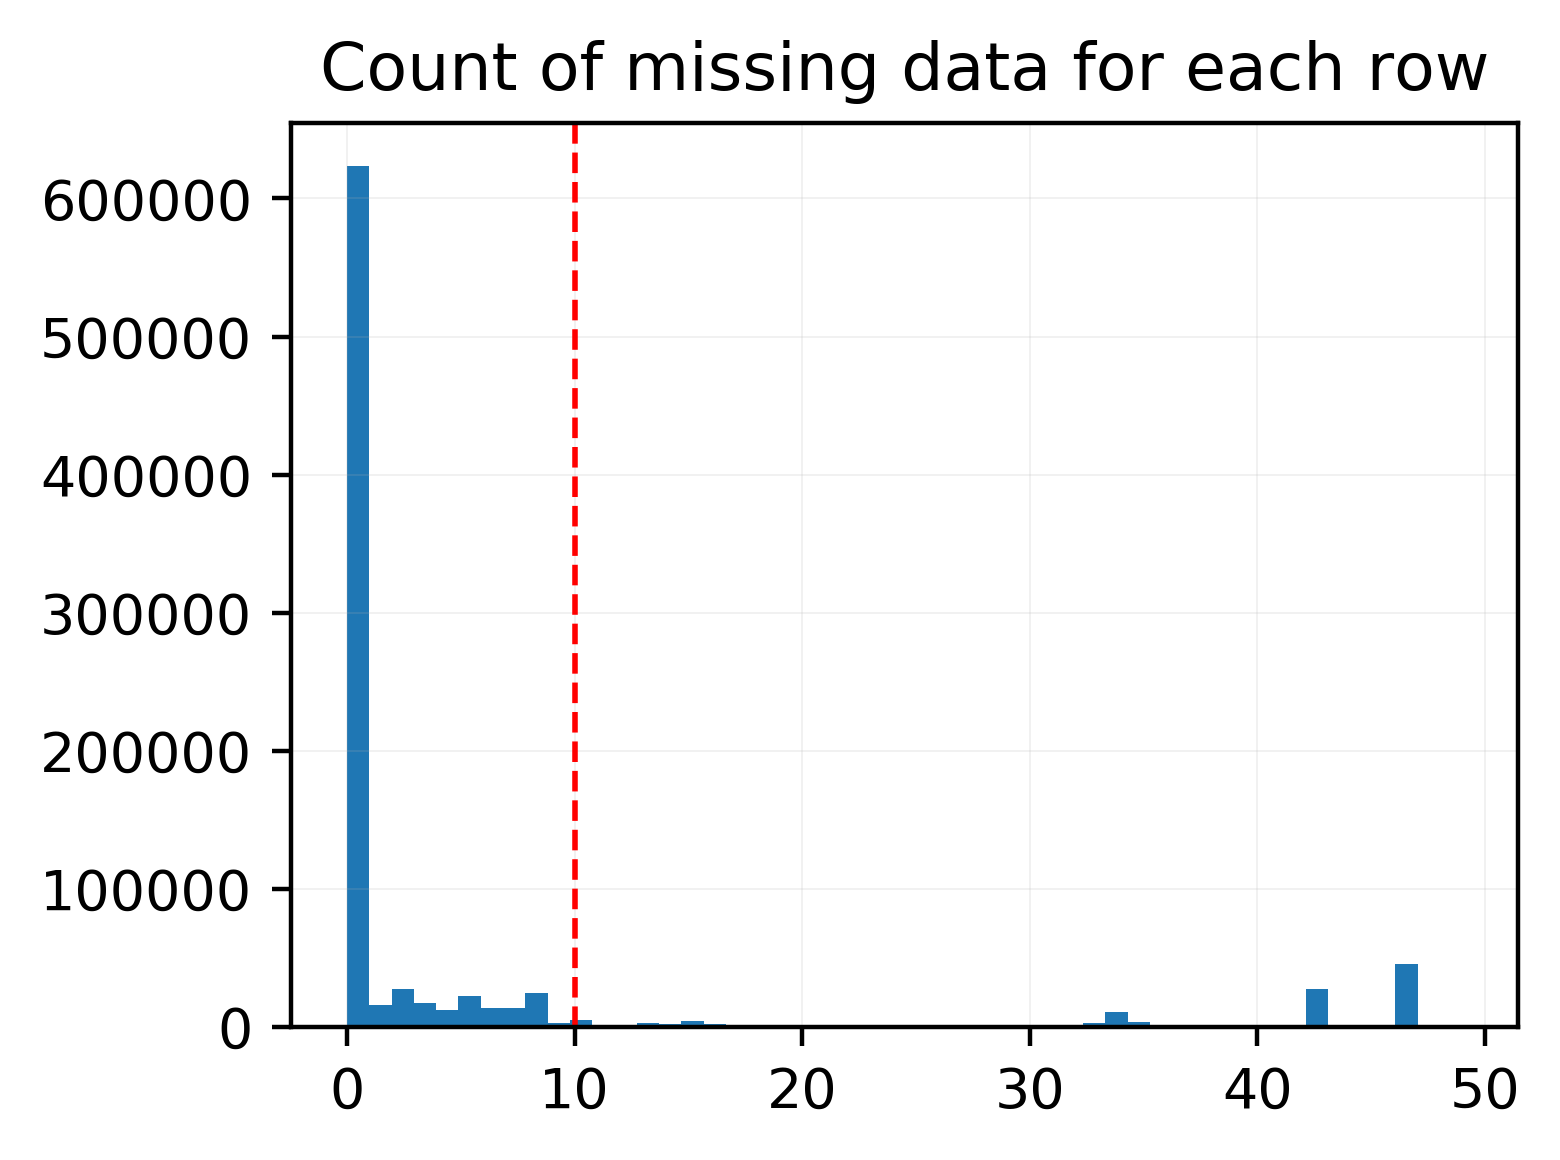

In [13]:
# How much data is missing in each row of the dataset?
array_count_missing_data_each_row \
    = np.array(array2d_nan_count !=0, dtype = int).sum(axis = 1)
# Investigate patterns in the amount of missing data in each column.
array_count_missing_data_each_row \
    = np.array(array2d_nan_count !=0, dtype = int).sum(axis = 1)
plt.close('all')
plt.figure(figsize = (4,3), dpi = 400)

plt.hist(array_count_missing_data_each_row, bins = 50)

plt.title('Count of missing data for each row')
plt.grid(alpha = 0.2, linewidth = 0.3)
# plt.axhline(40000, linestyle = '--', linewidth = 0.5)
plt.tight_layout()
plt.axvline(int_threshold, linestyle = '--', color = 'red', linewidth = 1)
plt.show()


In [14]:

array_row_index_higher_missing \
    = np.argwhere(array_count_missing_data_each_row >= int_threshold).reshape(-1)
array_row_index_lower_missing \
    = np.argwhere(array_count_missing_data_each_row < int_threshold).reshape(-1)
# array_column_name_higher_missing \
#     = feat_info['attribute'].values[array_column_index_higher_missing]
# array_column_name_lower_missing \
#     = feat_info['attribute'].values[array_column_index_lower_missing]

dataframe_azdias_higher = azdias.loc[array_row_index_higher_missing, :]
dataframe_azdias_lower = azdias.loc[array_row_index_lower_missing, :]
array2d_nan_count_higher = array2d_nan_count[array_row_index_higher_missing, :]
array2d_nan_count_lower = array2d_nan_count[array_row_index_lower_missing, :]



# # Write code to divide the data into two subsets based on the number of missing
# # values in each row.

# int_threshold = 30

# array_row_index_higher_missing \
#     = np.argwhere(array_count_missing_data >= int_threshold).reshape(-1)
# array_row_index_lower_missing \
#     = np.argwhere(array_count_missing_data < int_threshold).reshape(-1)
# # array_column_name_higher_missing \
# #     = feat_info['attribute'].values[array_column_index_higher_missing]
# # array_column_name_lower_missing \
# #     = feat_info['attribute'].values[array_column_index_lower_missing]

# dataframe_azdias_higher = azdias.loc[array_row_index_higher_missing, :]
# dataframe_azdias_lower = azdias.loc[array_row_index_lower_missing, :]
# array2d_nan_count_higher = array2d_nan_count[array_row_index_higher_missing, :]
# array2d_nan_count_lower = array2d_nan_count[array_row_index_lower_missing, :]

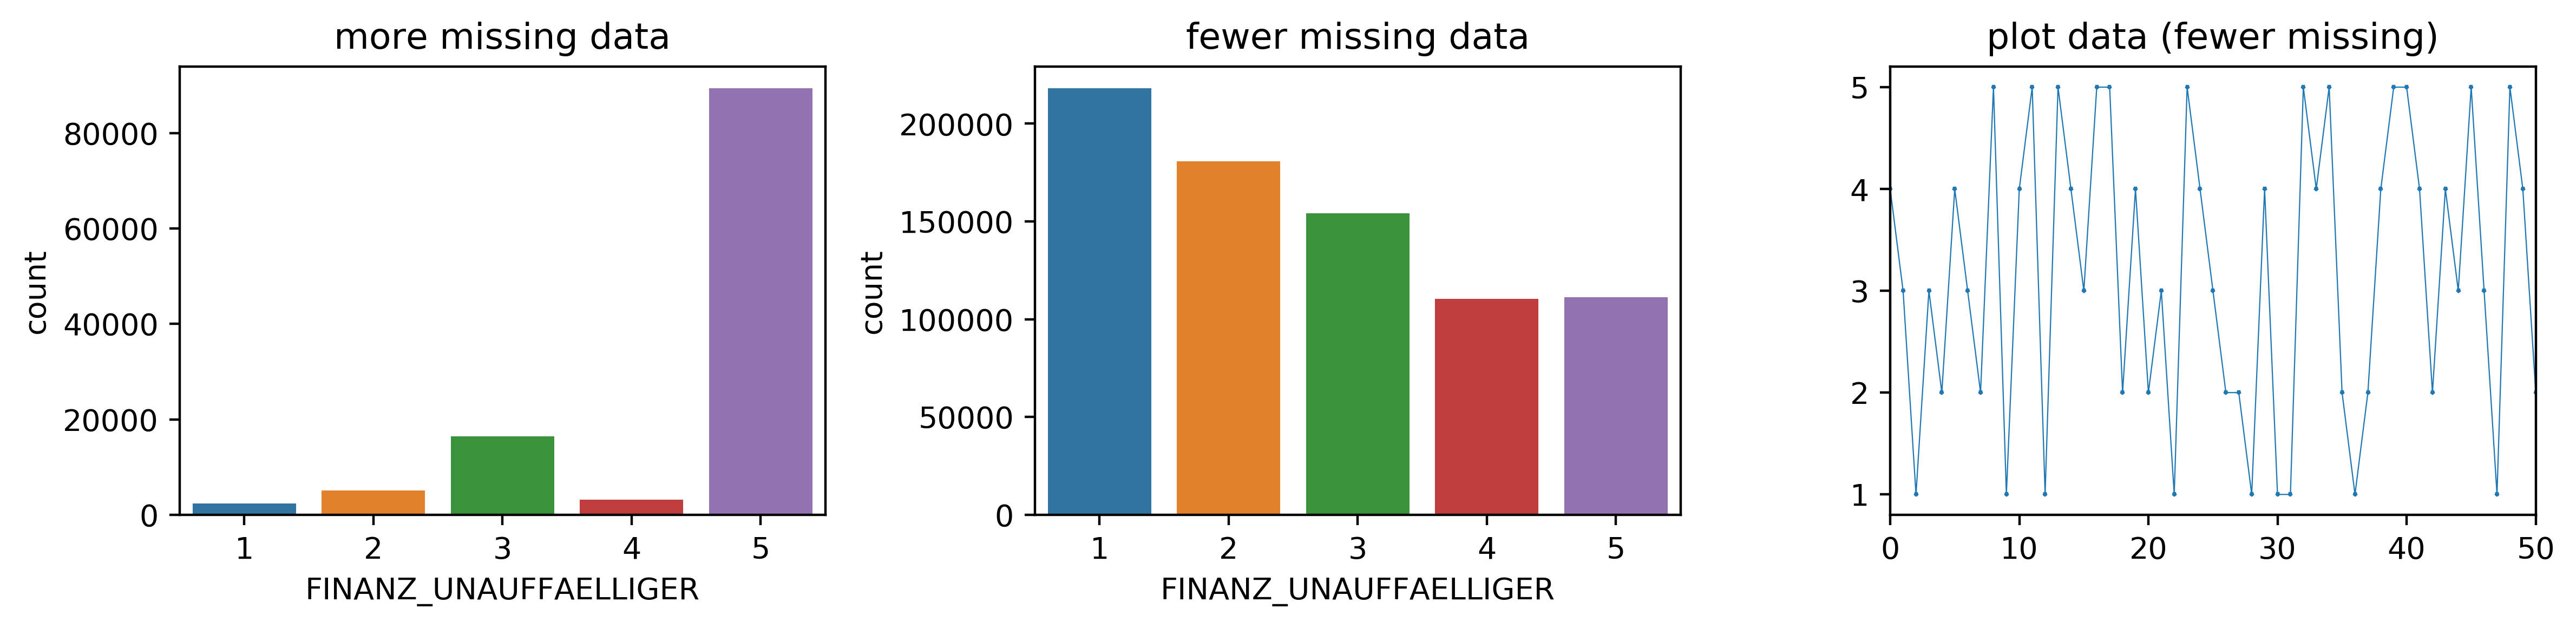

In [15]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.

def function_compare_dist(i_column):
    plt.figure(figsize= (12,3), dpi =400, facecolor = 'white')
    str_name_col = dataframe_azdias_lower.columns[i_column]
    plt.subplot(131)
    plt.title('more missing data')
    sns.countplot(data=dataframe_azdias_higher, x=str_name_col)
    #     plt.subplot(142)
    #     plt.plot(dataframe_azdias_higher[str_name_col].values, linestyle = '', marker = '*', markersize = 1)
    #     plt.title('plot data (more missing)')
    #     plt.xlim([0,50])
    plt.subplot(132)
    plt.title('fewer missing data')
    sns.countplot(data=dataframe_azdias_lower, x=str_name_col)
    plt.subplot(133)
    plt.plot(dataframe_azdias_lower[str_name_col].values, linestyle = '-', linewidth = 0.4, marker = '*', markersize = 1)
    plt.title('plot data (fewer missing)')
    plt.xlim([0,50])
    plt.tight_layout()
    plt.show()
for i_column in [1,3,5,7,15,20]:
    function_compare_dist(i_column)

#### Discussion 1.1.3: Assess Missing Data in Each Row

(Double-click this cell and replace this text with your own text, reporting your observations regarding missing data in rows. Are the data with lots of missing values are qualitatively different from data with few or no missing values?)

###### Conclusions
<span style="color:blue;">
For some columns, the distributions of non-missing features are similar between the data with more missing values and the data with fewer missing values, meaning dropping these data will not alter the result.
    
While for some columns, the distibutions of data with more missing values are very different from the data with few or no missing values, indicating more attentions need to be paid.
    
- These rows with many missing data will be dropped.
    
- As shown in the figure above, the data are usually equal to the nearest neighbor. So, for rows with less missing data will be interpolated based on the nearest mean. 
</span>

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [16]:
tuple_function_return \
    = np.unique(
        feat_info['type'].values, 
        return_inverse= True, 
        return_counts = True)
array_unique_type = tuple_function_return[0]
array_unique_inverse = tuple_function_return[1]
array_unique_count = tuple_function_return[2]

In [17]:
# How many features are there of each data type?
print('There are {} data types'.format(len(array_unique_type)))
for i_type in range(array_unique_type.size):
    print('Type: {}'.format(array_unique_type[i_type]).ljust(22), end = '')
    print('Count: {}'.format(array_unique_count[i_type]).ljust(18), end = '\n')
    temp_array_index = np.argwhere(array_unique_inverse == i_type).reshape(-1)
    array_column_name = feat_info['attribute'].values[temp_array_index]
    for str_column_name in array_column_name:
        temp_array_feature \
            = np.unique(
                dataframe_azdias_lower[str_column_name].to_numpy(dtype = str))
        int_feature_number = temp_array_feature.size
        print('\tCol name: {}'.format(str_column_name).ljust(30), end = '')
        print('Feature number: {}'.format(int_feature_number))
    print('\n')

There are 4 data types
Type: categorical     Count: 18         
	Col name: ANREDE_KZ          Feature number: 2
	Col name: CJT_GESAMTTYP      Feature number: 6
	Col name: FINANZTYP          Feature number: 6
	Col name: GFK_URLAUBERTYP    Feature number: 12
	Col name: GREEN_AVANTGARDE   Feature number: 2
	Col name: LP_FAMILIE_FEIN    Feature number: 12
	Col name: LP_FAMILIE_GROB    Feature number: 6
	Col name: LP_STATUS_FEIN     Feature number: 10
	Col name: LP_STATUS_GROB     Feature number: 5
	Col name: NATIONALITAET_KZ   Feature number: 4
	Col name: SHOPPER_TYP        Feature number: 5
	Col name: SOHO_KZ            Feature number: 2
	Col name: VERS_TYP           Feature number: 3
	Col name: ZABEOTYP           Feature number: 6
	Col name: GEBAEUDETYP        Feature number: 7
	Col name: OST_WEST_KZ        Feature number: 2
	Col name: CAMEO_DEUG_2015    Feature number: 10
	Col name: CAMEO_DEU_2015     Feature number: 45


Type: mixed           Count: 6          
	Col name: LP_LEBENSPHAS

In [18]:
i_type = 0
print('Type: {}'.format(array_unique_type[i_type]).ljust(22), end = '')
print('Count: {}'.format(array_unique_count[i_type]).ljust(18), end = '')
temp_array_index = np.argwhere(array_unique_inverse == i_type).reshape(-1)
array_column_name = feat_info['attribute'].values[temp_array_index]
temp_array_feature \
    = np.unique(
        dataframe_azdias_lower[array_column_name].to_numpy(dtype = str))
int_feature_number = temp_array_feature.size
print('Feature number: {}'.format(int_feature_number))


Type: categorical     Count: 18         Feature number: 70


#### Conclusions
- <span style="color:blue">The feature numbers are different for different types</span>
- <span style="color:blue">Numeric values have the larges number of unique values</span>
- <span style="color:blue">Oridinal values have 11 features, which is normal</span>
- <span style="color:blue">There are 45 categorical features for "CAMEO_DEU_2015"</span>



#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [19]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?

i_type = 0
print('Type: {}, Binary check'.format(array_unique_type[i_type]).ljust(22), end = '\n')
temp_array_index = np.argwhere(array_unique_inverse == i_type).reshape(-1)
array_column_name_catetory = feat_info['attribute'].values[temp_array_index]
array_if_binary = np.zeros(array_column_name_catetory.size, dtype = 'bool')
for i_col in range(len(array_column_name_catetory)):
    str_column_name = array_column_name_catetory[i_col]
    temp_array_feature \
        = np.unique(
            dataframe_azdias_lower[str_column_name].to_numpy(dtype = str))
    int_feature_number = temp_array_feature.size
    if temp_array_feature.size == 2:
        array_if_binary[i_col] = 1
    else:
        pass

Type: categorical, Binary check


In [20]:
print('Binary categoriable variables are:', end = '\n')
for temp_str in array_column_name_catetory[np.argwhere(array_if_binary == 1).reshape(-1)]:
    print('\t', temp_str)
print('Multi-level categoriable variables are:', end = '\n')
for temp_str in array_column_name_catetory[np.argwhere(array_if_binary != 1).reshape(-1)]:
    print('\t', temp_str)

Binary categoriable variables are:
	 ANREDE_KZ
	 GREEN_AVANTGARDE
	 SOHO_KZ
	 OST_WEST_KZ
Multi-level categoriable variables are:
	 CJT_GESAMTTYP
	 FINANZTYP
	 GFK_URLAUBERTYP
	 LP_FAMILIE_FEIN
	 LP_FAMILIE_GROB
	 LP_STATUS_FEIN
	 LP_STATUS_GROB
	 NATIONALITAET_KZ
	 SHOPPER_TYP
	 VERS_TYP
	 ZABEOTYP
	 GEBAEUDETYP
	 CAMEO_DEUG_2015
	 CAMEO_DEU_2015


In [114]:
dataframe_azdias_lower.loc[:, 'OST_WEST_KZ'].replace({'W':0, 'O':1}, inplace=True);

In [87]:
temp_list_one_hot_name = [
'SHOPPER_TYP',
'CAMEO_DEUG_2015',]

temp_list_drop_name = [
    'FINANZTYP',
    'GEBAEUDETYP',
    'CJT_GESAMTTYP',
    'GFK_URLAUBERTYP',
    'LP_FAMILIE_FEIN',
    'LP_FAMILIE_GROB',
    'LP_STATUS_FEIN',
    'LP_STATUS_GROB',
    'NATIONALITAET_KZ',
    'VERS_TYP',
    'ZABEOTYP',
    'CAMEO_DEU_2015',
    ]

In [46]:
# Re-encode categorical variable(s) to be kept in the analysis.
for str_col_name in temp_list_one_hot_name:
    print("get dummy: ", str_col_name)
    #     dataframe_azdias_lower \
    #         = dataframe_azdias_lower \
    temp_dataframe_get_dummy = pd.get_dummies(dataframe_azdias_lower[str_col_name], prefix=str_col_name + '_')
    temp_list_col_name_dumy = temp_dataframe_get_dummy.columns.to_numpy()
    for temp_str_col_name in temp_list_col_name_dumy:
        dataframe_azdias_lower[temp_str_col_name] = temp_dataframe_get_dummy[temp_str_col_name]
    dataframe_azdias_lower.drop(str_col_name, axis = 1, inplace = True)

get dummy:  SHOPPER_TYP
get dummy:  CAMEO_DEUG_2015


In [49]:
for str_col_name in temp_list_drop_name:
    print("drop: ", str_col_name)
    dataframe_azdias_lower.drop(str_col_name, axis = 1, inplace = True)

drop:  FINANZTYP
drop:  GEBAEUDETYP
drop:  CJT_GESAMTTYP
drop:  GFK_URLAUBERTYP
drop:  LP_FAMILIE_FEIN
drop:  LP_FAMILIE_GROB
drop:  LP_STATUS_FEIN
drop:  LP_STATUS_GROB
drop:  NATIONALITAET_KZ
drop:  VERS_TYP
drop:  ZABEOTYP
drop:  CAMEO_DEU_2015


#### Discussion 1.2.1: Re-Encode Categorical Features

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding categorical features. Which ones did you keep, which did you drop, and what engineering steps did you perform?)

<span style="color:blue">

- For each category, there are a large number rows. 


    - 'SHOPPER_TYP' shopper type - one-hot
    - CAMEO_DEUG_2015 - Wealth - one -hot
    
    - 'FINANZTYP;',  Individual finnacial type  - dropped
    - GEBAEUDETYP - Two bulding types - dropped
    - 'CJT_GESAMTTYP;',  - Customer journay - Can be dropped
    - GFK_URLAUBERTYP - Vacation habits - Droped
    - LP_FAMILIE_FEIN - Family type - Droped
    - LP_FAMILIE_GROB - Family type - Droped
    - LP_STATUS_FEIN - Social type - Droped
    - LP_STATUS_GROB - Social type - Droped
    - NATIONALITAET_KZ - Nationality  - Droped (the info is to corse.
    - VERS_TYP - insurance - dropped
    - ZABEOTYP - energy consumption - dropped
    - CAMEO_DEU_2015 - Wealth - Fine - dropped
   
    
    
- I used the **get_dummies** function to get the one-hot encoding.
    
- I tried to keep all information since every data point is valuable.
    
- Later, if more drops are needed, I can also do it.
    

</span>

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [53]:
dataframe_azdias_lower_bak = dataframe_azdias_lower.copy()

In [54]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.
dataframe_azdias_lower['PRAEGENDE_JUGENDJAHRE'].head(10)

1     14.0
2     15.0
3      8.0
4      8.0
5      3.0
6     10.0
7      8.0
8     11.0
9     15.0
10     3.0
Name: PRAEGENDE_JUGENDJAHRE, dtype: float64

In [55]:
array2d_PJ = np.array([
    [1   , '40s',  'Mainstream',  'E+W'],
    [2   , '40s',  'Avantgarde',  'E+W'],
    [3   , '50s',  'Mainstream',  'E+W'],
    [4   , '50s',  'Avantgarde',  'E+W'],
    [5   , '60s',  'Mainstream',  'E+W'],
    [6   , '60s',  'Avantgarde',  'W']  ,
    [7   , '60s',  'Avantgarde',  'E']  ,
    [8   , '70s',  'Mainstream',  'E+W'],
    [9   , '70s',  'Avantgarde',  'E+W'],
    [10  , '80s',  'Mainstream',  'W']  ,
    [11  , '80s',  'Avantgarde',  'W']  ,
    [12  , '80s',  'Mainstream',  'E']  ,
    [13  , '80s',  'Avantgarde',  'E']  ,
    [14  , '90s',  'Mainstream',  'E+W'],
    [15  , '90s',  'Avantgarde',  'E+W'],
])

temp_PJ_i_col = 1
temp_array_unique, temp_array_inverse \
    = np.unique(array2d_PJ[:,temp_PJ_i_col], return_inverse=True)
print(temp_array_unique)
for i_value in range(temp_array_unique.size):
    print('\t', 
          temp_array_unique[i_value], 
          array2d_PJ[np.argwhere(temp_array_inverse == i_value).reshape(-1),0])
temp_PJ_i_col = 2
temp_array_unique, temp_array_inverse \
    = np.unique(array2d_PJ[:,temp_PJ_i_col], return_inverse=True)
print(temp_array_unique)
for i_value in range(temp_array_unique.size):
    print('\t', 
          temp_array_unique[i_value], 
          array2d_PJ[np.argwhere(temp_array_inverse == i_value).reshape(-1),0])

['40s' '50s' '60s' '70s' '80s' '90s']
	 40s ['1' '2']
	 50s ['3' '4']
	 60s ['5' '6' '7']
	 70s ['8' '9']
	 80s ['10' '11' '12' '13']
	 90s ['14' '15']
['Avantgarde' 'Mainstream']
	 Avantgarde ['2' '4' '6' '7' '9' '11' '13' '15']
	 Mainstream ['1' '3' '5' '8' '10' '12' '14']


In [56]:
def function_set_value_bool(value_x):
    dict_binary_mainstream_avantgrade \
        = {'Mainstream':[2,4,6,7,9, 11, 13, 15], 
           'Avantgarde':[1,3,5,8, 10, 12, 14]}
    i_key = 0
    str_dict_key = list(dict_binary_mainstream_avantgrade)[i_key]
    list_matching_value = dict_binary_mainstream_avantgrade[str_dict_key]
    if np.isnan(value_x):
        map_value_x = np.nan
    elif int(value_x) in list_matching_value:
        map_value_x = 0
    else:
        map_value_x = 1
    return map_value_x

def function_set_value_decade(value_x):
    dict_decades = {
            '40s':[1  , 2], 
            '50s':[3  , 4], 
            '60s':[5  , 6 ,7], 
            '70s':[8  , 9], 
            '80s':[10  , 11 ,12 ,13], 
            '90s':[14  , 15]}
    for i_key in range(len(dict_decades.keys())):
        str_dict_key = list(dict_decades)[i_key]
        list_matching_value = dict_decades[str_dict_key]
        if np.isnan(value_x):
            map_value_x = np.nan
        else:
            if int(value_x) in list_matching_value:
                map_value_x = i_key
    return map_value_x

In [60]:
dataframe_azdias_lower['PRAEGENDE_JUGENDJAHRE_bool_MA'] \
    = dataframe_azdias_lower['PRAEGENDE_JUGENDJAHRE'].apply(function_set_value_bool)

dataframe_azdias_lower['PRAEGENDE_JUGENDJAHRE_decade']\
    = dataframe_azdias_lower['PRAEGENDE_JUGENDJAHRE'].apply(function_set_value_decade)

# Drop PRAEGENDE_JUGENDJAHRE
dataframe_azdias_lower.drop('PRAEGENDE_JUGENDJAHRE', axis = 1, inplace = True)

In [62]:
dataframe_azdias_lower.head(8)

ALTERSKATEGORIE_GROB  ANREDE_KZ  FINANZ_MINIMALIST  FINANZ_SPARER  \
1                   1.0          2                  1              5   
2                   3.0          2                  1              4   
3                   4.0          2                  4              2   
4                   3.0          1                  4              3   
5                   1.0          2                  3              1   
6                   2.0          2                  1              5   
7                   1.0          1                  3              3   
8                   3.0          1                  4              4   

   FINANZ_VORSORGER  FINANZ_ANLEGER  FINANZ_UNAUFFAELLIGER  FINANZ_HAUSBAUER  \
1                 2               5                      4                 5   
2                 1               2                      3                 5   
3                 5               2                      1                 2   
4                 4               1                      3                 2   
5                 5               2                      2                 5   
6                 1               5                      4                 3   
7                 4               1                      3                 2   
8                 2               4                      2                 2   

   GREEN_AVANTGARDE  HEALTH_TYP  ...  CAMEO_DEUG_2015__2  CAMEO_DEUG_2015__3  \
1                 0         3.0  ...                   0                   0   
2                 1         3.0  ...                   0                   0   
3                 0         2.0  ...                   1                   0   
4                 0         3.0  ...                   0                   0   
5                 0         3.0  ...                   0                   0   
6                 0         2.0  ...                   0                   0   
7                 0         1.0  ...                   1                   0   
8                 1         3.0  ...                   0                   0   

   CAMEO_DEUG_2015__4  CAMEO_DEUG_2015__5  CAMEO_DEUG_2015__6  \
1                   0                   0                   0   
2                   1                   0                   0   
3                   0                   0                   0   
4                   0                   0                   1   
5                   0                   0                   0   
6                   1                   0                   0   
7                   0                   0                   0   
8                   0                   0                   0   

   CAMEO_DEUG_2015__7  CAMEO_DEUG_2015__8  CAMEO_DEUG_2015__9  \
1                   0                   1                   0   
2                   0                   0                   0   
3                   0                   0                   0   
4                   0                   0                   0   
5                   0                   1                   0   
6                   0                   0                   0   
7                   0                   0                   0   
8                   0                   0                   0   

   PRAEGENDE_JUGENDJAHRE_bool_MA  PRAEGENDE_JUGENDJAHRE_decade  
1                            1.0                           5.0  
2                            0.0                           5.0  
3                            1.0                           3.0  
4                            1.0                           3.0  
5                            1.0                           1.0  
6                            1.0                           4.0  
7                            1.0                           3.0  
8                            0.0                           4.0  

[8 rows x 79 columns]

In [63]:
print("""
11: Wealthy Households - Pre-Family Couples & Singles
12: Wealthy Households - Young Couples With Children
13: Wealthy Households - Families With School Age Children
14: Wealthy Households - Older Families & Mature Couples
15: Wealthy Households - Elders In Retirement
21: Prosperous Households - Pre-Family Couples & Singles
22: Prosperous Households - Young Couples With Children
23: Prosperous Households - Families With School Age Children
24: Prosperous Households - Older Families & Mature Couples
25: Prosperous Households - Elders In Retirement
31: Comfortable Households - Pre-Family Couples & Singles
32: Comfortable Households - Young Couples With Children
33: Comfortable Households - Families With School Age Children
34: Comfortable Households - Older Families & Mature Couples
35: Comfortable Households - Elders In Retirement
41: Less Affluent Households - Pre-Family Couples & Singles
42: Less Affluent Households - Young Couples With Children
43: Less Affluent Households - Families With School Age Children
44: Less Affluent Households - Older Families & Mature Couples
45: Less Affluent Households - Elders In Retirement
51: Poorer Households - Pre-Family Couples & Singles
52: Poorer Households - Young Couples With Children
53: Poorer Households - Families With School Age Children
54: Poorer Households - Older Families & Mature Couples
55: Poorer Households - Elders In Retirement
""")


11: Wealthy Households - Pre-Family Couples & Singles
12: Wealthy Households - Young Couples With Children
13: Wealthy Households - Families With School Age Children
14: Wealthy Households - Older Families & Mature Couples
15: Wealthy Households - Elders In Retirement
21: Prosperous Households - Pre-Family Couples & Singles
22: Prosperous Households - Young Couples With Children
23: Prosperous Households - Families With School Age Children
24: Prosperous Households - Older Families & Mature Couples
25: Prosperous Households - Elders In Retirement
31: Comfortable Households - Pre-Family Couples & Singles
32: Comfortable Households - Young Couples With Children
33: Comfortable Households - Families With School Age Children
34: Comfortable Households - Older Families & Mature Couples
35: Comfortable Households - Elders In Retirement
41: Less Affluent Households - Pre-Family Couples & Singles
42: Less Affluent Households - Young Couples With Children
43: Less Affluent Households - Familie

In [64]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.
def function_set_value_CAMEO_WPCL(int_X):
    # print(int_X, type(int_X))
    try:
        map_int_x = int(str(int_X)[0])
    except:
        map_int_x = np.nan
    return map_int_x
def function_set_value_CAMEO_PYFOE(int_X):
    try:
        map_int_x = int(str(int_X)[1])
    except:
        map_int_x = np.nan
    return map_int_x
dataframe_azdias_lower['CAMEO_INTL_2015'].head(10)

1     51
2     24
3     12
4     43
5     54
6     22
7     14
8     13
9     15
10    51
Name: CAMEO_INTL_2015, dtype: object

In [65]:
dataframe_azdias_lower['CAMEO_INTL_2015_WPCL'] \
    = dataframe_azdias_lower['CAMEO_INTL_2015'].apply(function_set_value_CAMEO_WPCL)
dataframe_azdias_lower['CAMEO_INTL_2015_PYFOE'] \
    = dataframe_azdias_lower['CAMEO_INTL_2015'].apply(function_set_value_CAMEO_PYFOE)
dataframe_azdias_lower \
    = dataframe_azdias_lower.drop('CAMEO_INTL_2015', axis = 1)

In [66]:
print("""
There are 6 mixed types
Col name: LP_LEBENSPHASE_FEIN
Col name: LP_LEBENSPHASE_GROB
Col name: PRAEGENDE_JUGENDJAHRE (Converted)
Col name: WOHNLAGE         
Col name: CAMEO_INTL_2015   (Converted)
Col name: PLZ8_BAUMAX      
""")


There are 6 mixed types
Col name: LP_LEBENSPHASE_FEIN
Col name: LP_LEBENSPHASE_GROB
Col name: PRAEGENDE_JUGENDJAHRE (Converted)
Col name: WOHNLAGE         
Col name: CAMEO_INTL_2015   (Converted)
Col name: PLZ8_BAUMAX      



In [67]:
def function_set_int_value_CAMEO_WPCL(int_X):
    # print(int_X, type(int_X))
    try:
        map_int_x = int(str(int_X)[0])
    except:
        map_int_x = np.nan
    return map_int_x

In [68]:
temp_list_col_name_drop = [
    'LP_LEBENSPHASE_FEIN', 
    'PLZ8_BAUMAX', 
]

temp_list_col_name_one_hot = [
    'LP_LEBENSPHASE_GROB', 
]

In [69]:
for i_col_name_temp in range(0, len(temp_list_col_name_drop)):
    str_col_name = temp_list_col_name_drop[i_col_name_temp]
    print('dropping', str_col_name)
    dataframe_azdias_lower \
        = dataframe_azdias_lower.drop(str_col_name, axis = 1)

dropping LP_LEBENSPHASE_FEIN
dropping PLZ8_BAUMAX


In [71]:
for i_col_name_temp in range(0, len(temp_list_col_name_one_hot)):
    str_col_name = temp_list_col_name_one_hot[i_col_name_temp]
    print('getting dummies', str_col_name)
    
    temp_dataframe_get_dummy \
        = pd.get_dummies(
            dataframe_azdias_lower[str_col_name], 
            prefix = str_col_name + '_')
    temp_list_col_name_dumy = temp_dataframe_get_dummy.columns.to_numpy()
    for temp_str_col_name in temp_list_col_name_dumy:
        dataframe_azdias_lower[temp_str_col_name] \
            = temp_dataframe_get_dummy[temp_str_col_name]
    dataframe_azdias_lower \
        = dataframe_azdias_lower.drop(str_col_name, axis = 1)

getting dummies LP_LEBENSPHASE_GROB


#### Discussion 1.2.2: Engineer Mixed-Type Features

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding mixed-value features. Which ones did you keep, which did you drop, and what engineering steps did you perform?)

<span style="color:blue">
For other categories, there are either too many features that cannot be decoupled or too less features that do not need to be decoupled. 
I have two options: 
    
- Drop them 
- Convert to one-hot dummies

I tried to converted them to one-hot dummies as I want to keep all the data for the analysis. But I found it will eat up my memory.
I carefully checked the data.

1. WOHNLAGE is the neightborhodd quality. I think this is very important, so I must keep it. Additionally the label is positively related to the index value. So, it can be directly kept.
2. PLZ8_BAUMAX means how many pepole in one home, which does not affect the shopping habbit. I can drop it without much effects on the analysis results.
3. LP_LEBENSPHASE_GROB is about the income level, I  dirctly converted it to one-hot encoding.
4. LP_LEBENSPHASE_FEIN is find scale life stage, which is already contained in LP_LEBENSPHASE_GROB, I will drop it.

If the data is too big to be processed, I can still pick up the dropped columns.
</span>

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [75]:
dataframe_azdias_lower.shape

(774743, 89)

In [79]:
# If there are other re-engineering tasks you need to perform, make sure you
# take care of them here. (Dealing with missing data will come in step 2.1
dataframe_azdias_lower.isnull().sum()

ALTERSKATEGORIE_GROB         2596
ANREDE_KZ                       0
FINANZ_MINIMALIST               0
FINANZ_SPARER                   0
FINANZ_VORSORGER                0
                             ... 
LP_LEBENSPHASE_GROB__8.0        0
LP_LEBENSPHASE_GROB__9.0        0
LP_LEBENSPHASE_GROB__10.0       0
LP_LEBENSPHASE_GROB__11.0       0
LP_LEBENSPHASE_GROB__12.0       0
Length: 89, dtype: int64

In [83]:
for str_col_name in dataframe_azdias_lower.columns:
    dataframe_azdias_lower[str_col_name] \
        = dataframe_azdias_lower[str_col_name].interpolate(limit_direction='both')

In [86]:
# Do whatever you need to in order to ensure that the dataframe only contains
# the columns that should be passed to the algorithm functions.
print(dataframe_azdias_lower.isnull().sum())
print('No NaN alue found')

ALTERSKATEGORIE_GROB         0
ANREDE_KZ                    0
FINANZ_MINIMALIST            0
FINANZ_SPARER                0
FINANZ_VORSORGER             0
                            ..
LP_LEBENSPHASE_GROB__8.0     0
LP_LEBENSPHASE_GROB__9.0     0
LP_LEBENSPHASE_GROB__10.0    0
LP_LEBENSPHASE_GROB__11.0    0
LP_LEBENSPHASE_GROB__12.0    0
Length: 89, dtype: int64
No NaN alue found


### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [289]:
def clean_data(dataframe_to_be_cleaned):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', sep = ';')
    # Put in code here to execute all main cleaning steps:
    # convert missing value codes into NaNs, ...
    # Identify missing or unknown data values and convert them to NaNs.
    array2d_nan_count = dataframe_to_be_cleaned.isnull().to_numpy(dtype=int)
    array2d_nan_count[array2d_nan_count == 1] = -1
    list_nan_count = []
    for i_col_of_data in range(feat_info.shape[0]):
        list_nan_count.append([0,0])
        if len(feat_info['missing_or_unknown'][i_col_of_data]) == 2:
            pass
        else:
            temp_str_col_name = feat_info['attribute'][i_col_of_data]
            temp_array_str_invaid \
                = feat_info['missing_or_unknown'][i_col_of_data][1:-1].split(',')

            temp_count_index = 0
            for temp_invalid_str in temp_array_str_invaid:
                temp_count_index += 1
                if temp_invalid_str.find('X') >= 0:
                    temp_index_found \
                        = (dataframe_to_be_cleaned[temp_str_col_name].values == temp_invalid_str)
                    array2d_nan_count[temp_index_found,i_col_of_data] \
                        = temp_count_index
                    dataframe_to_be_cleaned.replace(
                        {temp_str_col_name: temp_invalid_str}, 
                        np.nan, 
                        inplace=True)
                else:
                    temp_invalid_value = int(temp_invalid_str)
                    temp_index_found \
                        = (dataframe_to_be_cleaned[temp_str_col_name].values == temp_invalid_value)
                    array2d_nan_count[temp_index_found,i_col_of_data] \
                        = temp_count_index
                    dataframe_to_be_cleaned.replace(
                        {temp_str_col_name: temp_invalid_value}, 
                        np.nan, 
                        inplace=True)
    for i_col_of_data in range(feat_info.shape[0]):
        if len(feat_info['missing_or_unknown'][i_col_of_data]) == 2:
            pass
        else:
            temp_array_str_invaid \
                = feat_info['missing_or_unknown'][i_col_of_data][1:-1].split(',')
            temp_str_col_name = feat_info['attribute'][i_col_of_data]
            for temp_invalid_str in temp_array_str_invaid:
                if temp_invalid_str.find('X') >= 0:
                    dataframe_to_be_cleaned.replace(
                        {temp_str_col_name: temp_invalid_str}, 
                        np.nan, 
                        inplace=True)                        
                else:
                    temp_invalid_value = int(temp_invalid_str)
                    dataframe_to_be_cleaned.replace(
                        {temp_str_col_name: temp_invalid_value}, 
                        np.nan, 
                        inplace=True)       
    # remove selected columns and rows, ...
    ## Remove cols
    int_columns_thresold = 200000
    temp_array_index_higher_missing = np.argwhere(array_count_missing_data > int_columns_thresold).reshape(-1)
    array_index_outlier = temp_array_index_higher_missing.copy()
    array_drop_label = feat_info['attribute'].values[array_index_outlier]
    dataframe_to_be_cleaned = dataframe_to_be_cleaned.drop(array_drop_label, axis = 1)
    feat_info = feat_info.drop(array_index_outlier, axis = 0)
    array2d_nan_count = np.delete(array2d_nan_count, array_index_outlier, 1)
    ## Remove rows

    int_threshold = 10
    array_count_missing_data_each_row \
        = np.array(array2d_nan_count !=0, dtype = int).sum(axis = 1)
    # Investigate patterns in the amount of missing data in each column.
    array_count_missing_data_each_row \
        = np.array(array2d_nan_count !=0, dtype = int).sum(axis = 1)
    array_row_index_higher_missing \
        = np.argwhere(array_count_missing_data_each_row >= int_threshold).reshape(-1)
    array_row_index_lower_missing \
        = np.argwhere(array_count_missing_data_each_row < int_threshold).reshape(-1)
    # array_column_name_higher_missing \
    #     = feat_info['attribute'].values[array_column_index_higher_missing]
    # array_column_name_lower_missing \
    #     = feat_info['attribute'].values[array_column_index_lower_missing]

    dataframe_dataframe_to_be_cleaned_higher = dataframe_to_be_cleaned.loc[array_row_index_higher_missing, :]
    dataframe_dataframe_to_be_cleaned_lower = dataframe_to_be_cleaned.loc[array_row_index_lower_missing, :]
    array2d_nan_count_higher = array2d_nan_count[array_row_index_higher_missing, :]
    array2d_nan_count_lower = array2d_nan_count[array_row_index_lower_missing, :]

    # select, re-encode, and engineer column values.

    temp_list_one_hot_name = [
        'SHOPPER_TYP',
        'CAMEO_DEUG_2015',]

    temp_list_drop_name = [
        'FINANZTYP',
        'GEBAEUDETYP',
        'CJT_GESAMTTYP',
        'GFK_URLAUBERTYP',
        'LP_FAMILIE_FEIN',
        'LP_FAMILIE_GROB',
        'LP_STATUS_FEIN',
        'LP_STATUS_GROB',
        'NATIONALITAET_KZ',
        'VERS_TYP',
        'ZABEOTYP',
        'CAMEO_DEU_2015',
        ]
    # Re-encode categorical variable(s) to be kept in the analysis.
    for str_col_name in temp_list_one_hot_name:
        print("get dummy: ", str_col_name)
        #     dataframe_dataframe_to_be_cleaned_lower \
        #         = dataframe_dataframe_to_be_cleaned_lower \
        temp_dataframe_get_dummy = pd.get_dummies(dataframe_dataframe_to_be_cleaned_lower[str_col_name], prefix=str_col_name + '_')
        temp_list_col_name_dumy = temp_dataframe_get_dummy.columns.to_numpy()
        for temp_str_col_name in temp_list_col_name_dumy:
            dataframe_dataframe_to_be_cleaned_lower[temp_str_col_name] = temp_dataframe_get_dummy[temp_str_col_name]
        dataframe_dataframe_to_be_cleaned_lower.drop(str_col_name, axis = 1, inplace = True)
    for str_col_name in temp_list_drop_name:
        print("drop: ", str_col_name)
        dataframe_dataframe_to_be_cleaned_lower.drop(str_col_name, axis = 1, inplace = True)
    def function_set_value_bool(value_x):
        dict_binary_mainstream_avantgrade \
            = {'Mainstream':[2,4,6,7,9, 11, 13, 15], 
            'Avantgarde':[1,3,5,8, 10, 12, 14]}
        i_key = 0
        str_dict_key = list(dict_binary_mainstream_avantgrade)[i_key]
        list_matching_value = dict_binary_mainstream_avantgrade[str_dict_key]
        if np.isnan(value_x):
            map_value_x = np.nan
        elif int(value_x) in list_matching_value:
            map_value_x = 0
        else:
            map_value_x = 1
        return map_value_x

    def function_set_value_decade(value_x):
        dict_decades = {
                '40s':[1  , 2], 
                '50s':[3  , 4], 
                '60s':[5  , 6 ,7], 
                '70s':[8  , 9], 
                '80s':[10  , 11 ,12 ,13], 
                '90s':[14  , 15]}
        for i_key in range(len(dict_decades.keys())):
            str_dict_key = list(dict_decades)[i_key]
            list_matching_value = dict_decades[str_dict_key]
            if np.isnan(value_x):
                map_value_x = np.nan
            else:
                if int(value_x) in list_matching_value:
                    map_value_x = i_key
        return map_value_x

    dataframe_dataframe_to_be_cleaned_lower['PRAEGENDE_JUGENDJAHRE_bool_MA'] \
        = dataframe_dataframe_to_be_cleaned_lower['PRAEGENDE_JUGENDJAHRE'].apply(function_set_value_bool)
    dataframe_dataframe_to_be_cleaned_lower.loc[:, 'OST_WEST_KZ'].replace({'W':0, 'O':1}, inplace=True);
 
    dataframe_dataframe_to_be_cleaned_lower['PRAEGENDE_JUGENDJAHRE_decade']\
        = dataframe_dataframe_to_be_cleaned_lower['PRAEGENDE_JUGENDJAHRE'].apply(function_set_value_decade)
    # Drop PRAEGENDE_JUGENDJAHRE
    dataframe_dataframe_to_be_cleaned_lower.drop('PRAEGENDE_JUGENDJAHRE', axis = 1, inplace = True)
    # Investigate "CAMEO_INTL_2015" and engineer two new variables.
    def function_set_value_CAMEO_WPCL(int_X):
        # print(int_X, type(int_X))
        try:
            map_int_x = int(str(int_X)[0])
        except:
            map_int_x = np.nan
        return map_int_x
    def function_set_value_CAMEO_PYFOE(int_X):
        try:
            map_int_x = int(str(int_X)[1])
        except:
            map_int_x = np.nan
        return map_int_x
    def function_set_value_CAMEO_WPCL(int_X):
        # print(int_X, type(int_X))
        try:
            map_int_x = int(str(int_X)[0])
        except:
            map_int_x = np.nan
        return map_int_x
    dataframe_dataframe_to_be_cleaned_lower['CAMEO_INTL_2015_WPCL'] \
        = dataframe_dataframe_to_be_cleaned_lower['CAMEO_INTL_2015'].apply(function_set_value_CAMEO_WPCL)
    dataframe_dataframe_to_be_cleaned_lower['CAMEO_INTL_2015_PYFOE'] \
        = dataframe_dataframe_to_be_cleaned_lower['CAMEO_INTL_2015'].apply(function_set_value_CAMEO_PYFOE)
    dataframe_dataframe_to_be_cleaned_lower \
        = dataframe_dataframe_to_be_cleaned_lower.drop('CAMEO_INTL_2015', axis = 1)
    temp_list_col_name_drop = [
        'LP_LEBENSPHASE_FEIN', 
        'PLZ8_BAUMAX', 
    ]

    temp_list_col_name_one_hot = [
        'LP_LEBENSPHASE_GROB', 
    ]
    for i_col_name_temp in range(0, len(temp_list_col_name_drop)):
        str_col_name = temp_list_col_name_drop[i_col_name_temp]
        print('dropping', str_col_name)
        dataframe_dataframe_to_be_cleaned_lower \
            = dataframe_dataframe_to_be_cleaned_lower.drop(str_col_name, axis = 1)
    
    for i_col_name_temp in range(0, len(temp_list_col_name_one_hot)):
        str_col_name = temp_list_col_name_one_hot[i_col_name_temp]
        print('getting dummies', str_col_name)
        
        temp_dataframe_get_dummy \
            = pd.get_dummies(
                dataframe_dataframe_to_be_cleaned_lower[str_col_name], 
                prefix = str_col_name + '_')
        temp_list_col_name_dumy = temp_dataframe_get_dummy.columns.to_numpy()
        for temp_str_col_name in temp_list_col_name_dumy:
            dataframe_dataframe_to_be_cleaned_lower[temp_str_col_name] \
                = temp_dataframe_get_dummy[temp_str_col_name]
        dataframe_dataframe_to_be_cleaned_lower \
            = dataframe_dataframe_to_be_cleaned_lower.drop(str_col_name, axis = 1)

    dataframe_dataframe_to_be_cleaned_lower.shape
    for str_col_name in dataframe_dataframe_to_be_cleaned_lower.columns:
        dataframe_dataframe_to_be_cleaned_lower[str_col_name] \
            = dataframe_dataframe_to_be_cleaned_lower[str_col_name].interpolate(limit_direction='both')
    # Return the cleaned dataframe.
    return dataframe_dataframe_to_be_cleaned_lower 

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [ ]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.



In [115]:
# Apply feature scaling to the general population demographics data.

scaler = preprocessing.StandardScaler()
dataframe_azdias_lower[dataframe_azdias_lower.columns] \
    = scaler.fit_transform(dataframe_azdias_lower.values)



In [118]:
dataframe_azdias_lower.head(10)

ALTERSKATEGORIE_GROB  ANREDE_KZ  FINANZ_MINIMALIST  FINANZ_SPARER  \
1               -1.76346   0.958422          -1.488785       1.540017   
2                0.19940   0.958422          -1.488785       0.867244   
3                1.18083   0.958422           0.689233      -0.478302   
4                0.19940  -1.043381           0.689233       0.194471   
5               -1.76346   0.958422          -0.036773      -1.151076   
6               -0.78203   0.958422          -1.488785       1.540017   
7               -1.76346  -1.043381          -0.036773       0.194471   
8                0.19940  -1.043381           0.689233       0.867244   
9                0.19940   0.958422          -0.762779       0.867244   
10               0.19940   0.958422          -0.762779      -0.478302   

    FINANZ_VORSORGER  FINANZ_ANLEGER  FINANZ_UNAUFFAELLIGER  FINANZ_HAUSBAUER  \
1          -1.044684        1.468541               0.981043          1.327209   
2          -1.770775       -0.568811               0.263375          1.327209   
3           1.133590       -0.568811              -1.171961         -0.818216   
4           0.407498       -1.247929               0.263375         -0.818216   
5           1.133590       -0.568811              -0.454293          1.327209   
6          -1.770775        1.468541               0.981043         -0.103075   
7           0.407498       -1.247929               0.263375         -0.818216   
8          -1.044684        0.789423              -0.454293         -0.818216   
9          -1.044684        0.110306               1.698711          0.612067   
10          1.133590        0.110306              -1.171961          1.327209   

    GREEN_AVANTGARDE  HEALTH_TYP  ...  LP_LEBENSPHASE_GROB__3.0  \
1          -0.531136    1.065592  ...                 -0.395627   
2           1.882757    1.065592  ...                 -0.395627   
3          -0.531136   -0.273227  ...                 -0.395627   
4          -0.531136    1.065592  ...                 -0.395627   
5          -0.531136    1.065592  ...                 -0.395627   
6          -0.531136   -0.273227  ...                 -0.395627   
7          -0.531136   -1.612046  ...                 -0.395627   
8           1.882757    1.065592  ...                  2.527631   
9           1.882757   -0.273227  ...                 -0.395627   
10         -0.531136   -0.273227  ...                 -0.395627   

    LP_LEBENSPHASE_GROB__4.0  LP_LEBENSPHASE_GROB__5.0  \
1                  -0.264077                 -0.249533   
2                  -0.264077                 -0.249533   
3                  -0.264077                 -0.249533   
4                  -0.264077                 -0.249533   
5                  -0.264077                 -0.249533   
6                  -0.264077                 -0.249533   
7                  -0.264077                 -0.249533   
8                  -0.264077                 -0.249533   
9                  -0.264077                 -0.249533   
10                 -0.264077                 -0.249533   

    LP_LEBENSPHASE_GROB__6.0  LP_LEBENSPHASE_GROB__7.0  \
1                   5.303158                 -0.165765   
2                  -0.188567                 -0.165765   
3                  -0.188567                 -0.165765   
4                  -0.188567                 -0.165765   
5                  -0.188567                 -0.165765   
6                  -0.188567                 -0.165765   
7                  -0.188567                 -0.165765   
8                  -0.188567                 -0.165765   
9                  -0.188567                 -0.165765   
10                 -0.188567                 -0.165765   

    LP_LEBENSPHASE_GROB__8.0  LP_LEBENSPHASE_GROB__9.0  \
1                  -0.190005                 -0.249723   
2                  -0.190005                 -0.249723   
3                  -0.190005                 -0.249723   
4                  -0.190005                 -0.249723   
5 

### Discussion 2.1: Apply Feature Scaling

(Double-click this cell and replace this text with your own text, reporting your decisions regarding feature scaling.)

I chose to use the standard scaler to normazed the dataset.
This choice fits the situation here since it doest not affect the distribution of the data and will not 
lead to skewed results.

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [121]:
from sklearn.decomposition import PCA    

In [167]:
%%time
# Apply PCA to the data.
pca = PCA()
dataframe_azdias_lower_pca = pca.fit_transform(dataframe_azdias_lower)


CPU times: user 17.6 s, sys: 1.66 s, total: 19.2 s
Wall time: 5.91 s


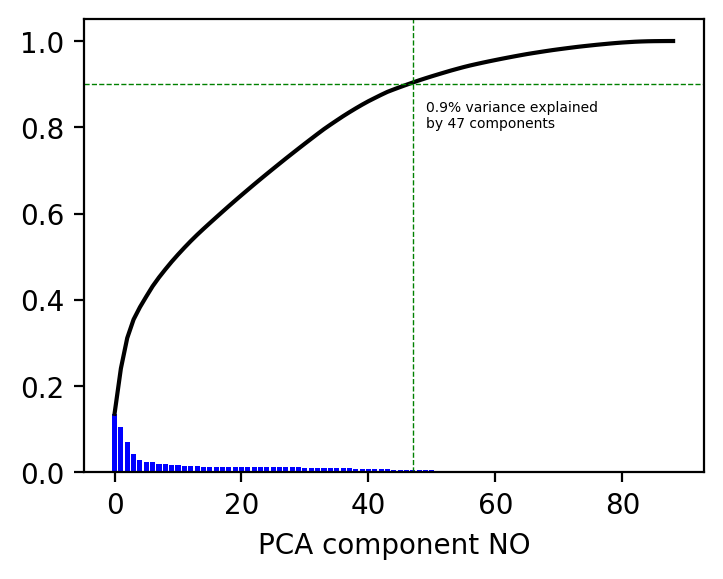

In [172]:
# Investigate the variance accounted for by each principal component.
array_variance_ratio = pca.explained_variance_ratio_
array_cum_variance = np.cumsum(array_variance_ratio)
int_component_number = array_variance_ratio.size
value_percentage = 0.9
int_index__min \
    = np.argwhere(np.abs(array_cum_variance - value_percentage) \
                      == np.abs(array_cum_variance - value_percentage).min()).reshape(-1)[0]
int_index__min = int_index__min + 1
plt.figure(figsize = (4,3), dpi =200)
plt.bar(range(array_cum_variance.size), array_variance_ratio, label = 'variance ratio', color = 'blue')
plt.plot(range(array_cum_variance.size), array_cum_variance, label = 'cum sum variance ratio', color = 'black')
plt.xlabel('PCA component NO')
plt.axhline(value_percentage, color = 'green', linewidth = 0.5, linestyle = '--',)
plt.axvline(int_index__min, color = 'green', linewidth = 0.5, linestyle = '--',)
plt.text(int_index__min + 2, value_percentage - 0.1, '\n{}% variance explained \nby {} components'.format(value_percentage, int_index__min), fontdict={'fontsize':5})
plt.show()

In [173]:
# Re-apply PCA to the data while selecting for number of components to retain.
pca = PCA(n_components= int_index__min)
dataframe_azdias_lower_pca = pca.fit_transform(dataframe_azdias_lower)


In [174]:
pca.explained_variance_ratio_.sum()

0.8985146362841282

### Discussion 2.2: Perform Dimensionality Reduction

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding dimensionality reduction. How many principal components / transformed features are you retaining for the next step of the analysis?)

<span style="color:blue">
I chose 90% energy covnerage (explainable vairance) for more information.
It is found that 47 component will cover 90% explainable variance.
So, 47 components are chosen.
</span>

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [223]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.
def get_pca_component_weights(pca, i_component):
    dict_weights = {}
    for i_feature, feature in enumerate(dataframe_azdias_lower.columns):
        dict_weights[feature] = pca.components_[i_component][i_feature]
    dict_weights_sorted \
        = {k: v for k, v in sorted(dict_weights.items(), key=lambda item: item[1], reverse=True)}
    return dict_weights_sorted


#pretty print

def plot_most_important_features(dict_weights):
    int_number_ = 5
    dict_weights_sorted \
        = {k: v for k, v in sorted(dict_weights.items(), key=lambda item: item[1], reverse=True)}

    list_keys = list(dict_weights_sorted)
    list_index \
        = np.append(
            np.arange(0, int_number_, 1), 
            np.arange(- int_number_, 0, 1))
    list_weight = []
    list_name = []
    for i_index in list_index:
        list_name.append(list_keys[i_index])
        list_weight.append(dict_weights_sorted[list_keys[i_index]])
    
    plt.figure(figsize = (4,3), dpi = 200, facecolor = 'white')
    plt.bar(range(len(list_weight)), list_weight)
    plt.xticks(range(len(list_weight)), list_name, rotation = 75)
    plt.grid(True, linewidth = 0.3, alpha = 0.3, )
    return None

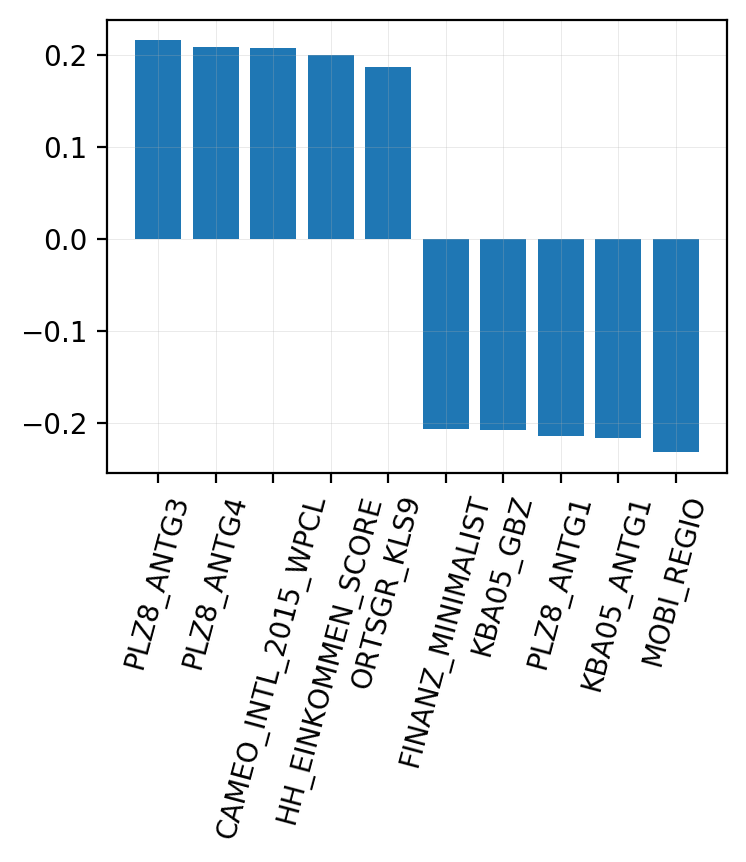

In [225]:
dict_weights = get_pca_component_weights(pca,0)
plot_most_important_features(dict_weights)


### Discussion 2.3.1 First principle component
It seems that the first principle component is largely concerned with faimiliy homes with 6-10+ houses in the PLZ8 region.
It is positively related to the wealth (CAMEO_INTL_2015.
IT is negatibvely related to movement pattersn, which is reasonable 
since the frequently moving people tends to travel less

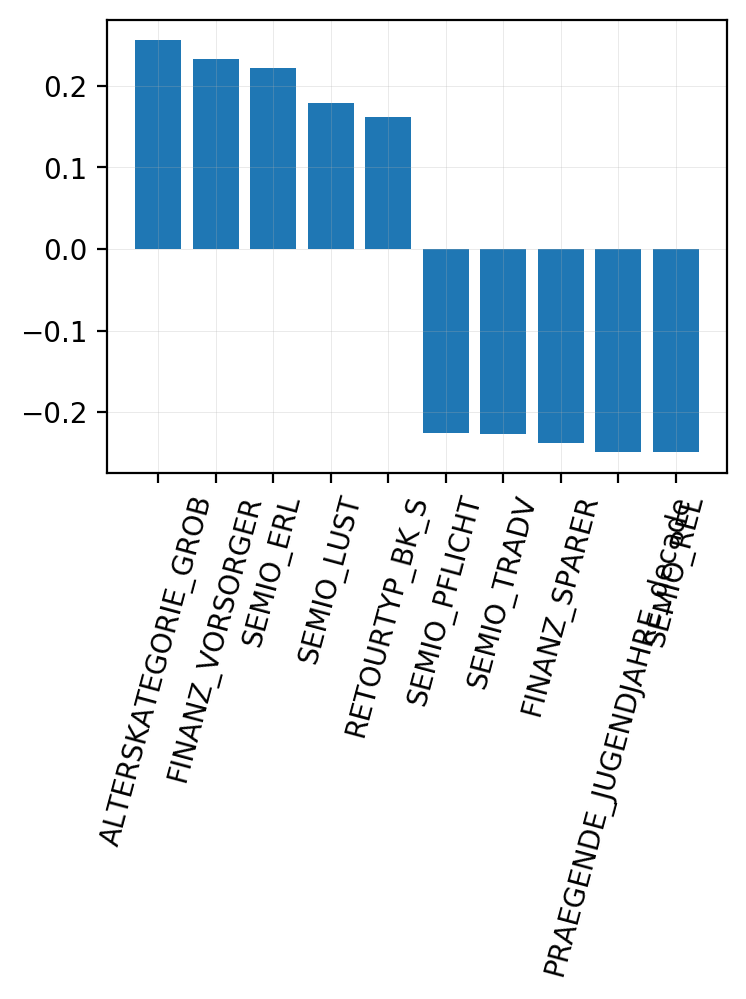

In [226]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.


dict_weights = get_pca_component_weights(pca,1)
plot_most_important_features(dict_weights)

### Discussion 2.3.2 Second principle component
It seems that the second principle component is largely concerned with ages.
It is positively related to the whether the customer is finantially be prepared.
IT is negatibvely related to SEMIO_REL (event-roiented) and SEMIO_TRADV (traditional-minded), which is also reasonable since these features are related to personality.
The negative realtion with movement of person's youth is also reasonable
since usually a unhapy childhoood will make people shopping less and save 
more.

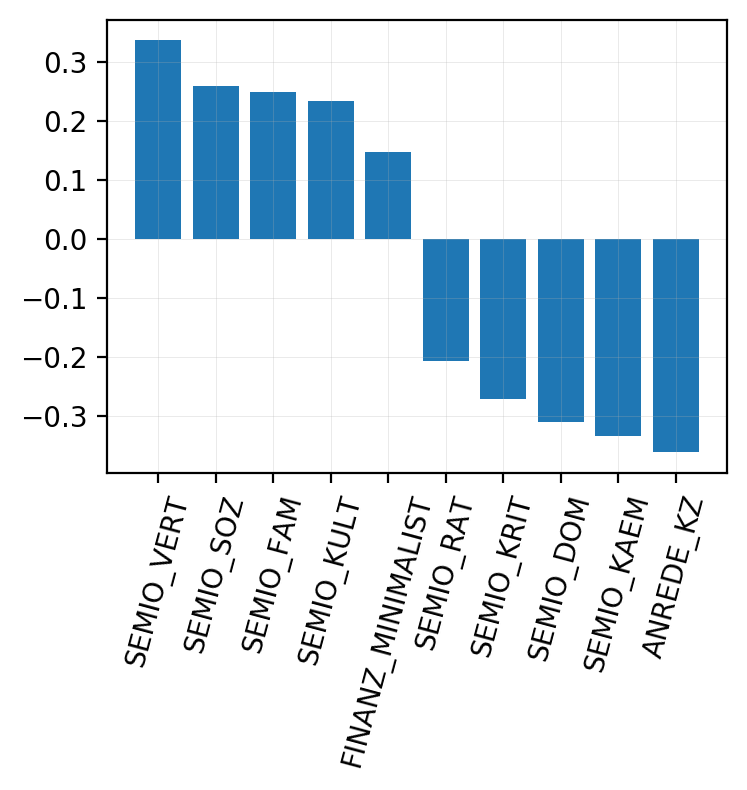

In [227]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.

dict_weights = get_pca_component_weights(pca,2)
plot_most_important_features(dict_weights)

### Discussion 2.3.3 Third principle component
It seems that the second principle component is largely concerned with dreamful personality, social mind, and family minded. 
IT is also highly related to gender, which is reasonable.
It is negatively related to  combative attitude.


### Discussion 2.3: Interpret Principal Components

(Double-click this cell and replace this text with your own text, reporting your observations from detailed investigation of the first few principal components generated. Can we interpret positive and negative values from them in a meaningful way?)

The principle components were disscussed in the cells above.

## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [231]:
dataframe_azdias_lower_pca.shape

(774743, 47)

In [241]:
# Over a number of different cluster counts...
def function_k_means(array2d_data, int_numbe_cluster):
    # run k-means clustering on the data and...
    kmeans = KMeans(n_clusters=int_numbe_cluster)
    k_means_model = kmeans.fit(array2d_data)
    # compute the average within-cluster distances.
    value_dist = np.abs(k_means_model.score(array2d_data))
    return value_dist

In [384]:
%%time
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.
array_cluster_number = np.arange(1,30)
array_dist = np.zeros(array_cluster_number.size)
for i_number in range(19, len(array_cluster_number)):
    print('working on ', i_number)
    int_numbe_cluster = array_cluster_number[i_number]
    array_dist[i_number] \
        = function_k_means(dataframe_azdias_lower_pca, int_numbe_cluster)


working on  19
working on  20
working on  21
working on  22
working on  23
working on  24
working on  25
working on  26
working on  27
working on  28
CPU times: user 43min 40s, sys: 10min 43s, total: 54min 23s
Wall time: 45min 28s


In [387]:
array_dist[:] = [
    61954495.31242203, 
    54802268.32011243, 
    51183458.89192706,
    48923364.10447177, 
    47531444.61710145, 
    46212338.48540854,
    45094289.29173987, 
    44195742.11941613, 
    43533304.80866303,
    42939086.62326069, 
    42411209.00067225, 
    41679791.88413186,
    41313248.92333466, 
    40559916.06175825, 
    40489622.55628721, 
    39782666.20526294, 
    39317822.78634909, 
    38994726.95241727, 
    38811256.02361010, 
    38232765.64274950, 
    37781550.75820151,
    37894546.41416295, 
    37458915.26815581, 
    36916063.70506822,
    36836771.90172290, 
    36419479.73113818,
    36062256.72652353,
    36020426.76802757,
    35696173.4250766 
]

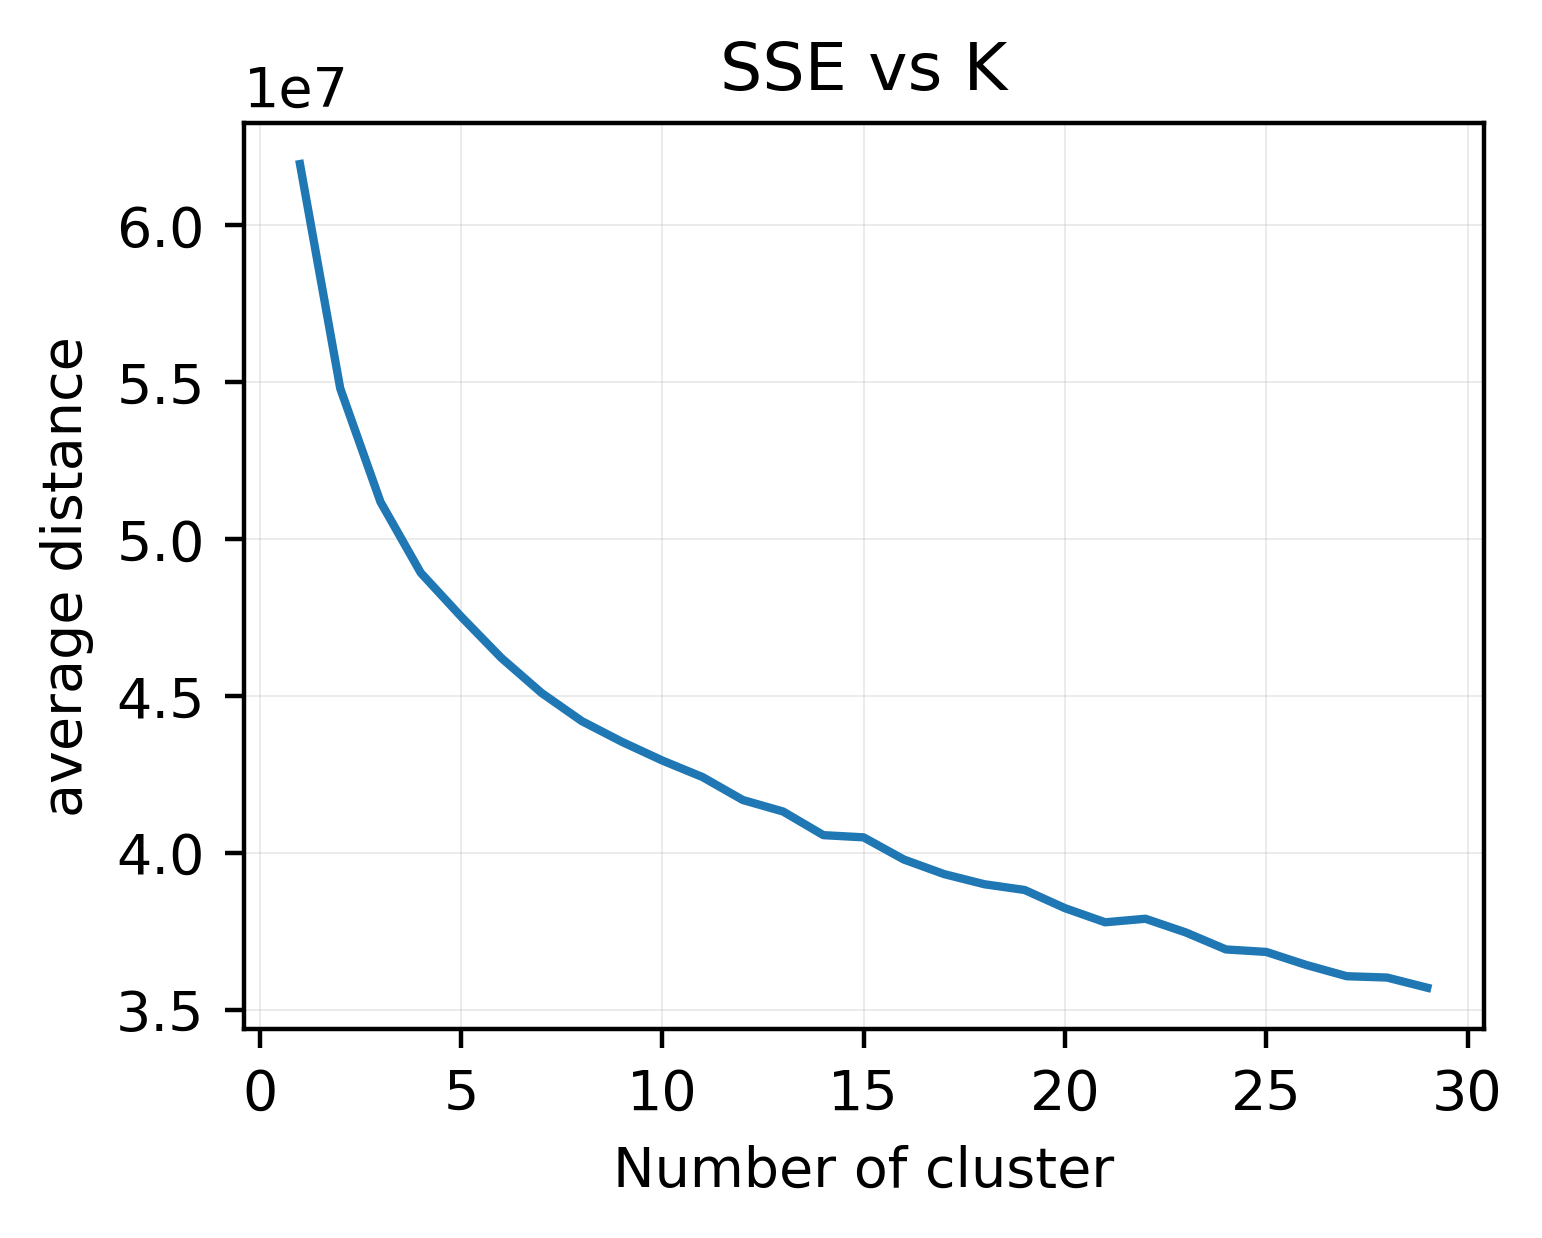

In [388]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.
plt.figure(figsize = (4,3), dpi = 400, facecolor = 'white')
plt.plot(array_cluster_number, array_dist)
plt.grid(linewidth = 0.3, alpha = 0.3)
plt.xlabel('Number of cluster')
plt.ylabel('average distance')
plt.title('SSE vs K')
plt.show()


In [265]:
%%time
kmeans = KMeans(n_clusters=14)
k_means_model = kmeans.fit(array2d_data)
model_redict_country_data = k_means_model.predict(dataframe_azdias_lower_pca)

CPU times: user 2min 16s, sys: 28.5 s, total: 2min 45s
Wall time: 2min 18s


### Discussion 3.1: Apply Clustering to General Population

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding clustering. Into how many clusters have you decided to segment the population?)

<span style="color:blue">
I decided to use 14 cluster. While the elbow is not clear in the above figure,
it seems 14 is a good balance. After 14 cluster, the variation becomes small.
</span>

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [266]:
# Load in the customer demographics data.
data_frame_customers = pd.read_csv('Udacity_CUSTOMERS_Subset.csv', sep = ';')

In [290]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.
customers_cleaned = clean_data(data_frame_customers)
customers_cleaned.head()

customers_cleaned[customers_cleaned.columns] \
    = scaler.transform(customers_cleaned.values)
customers_cleaned_pca = pca.transform(customers_cleaned)
model_redict_customer_data = k_means_model.predict(customers_cleaned_pca)

get dummy:  SHOPPER_TYP
get dummy:  CAMEO_DEUG_2015
drop:  FINANZTYP
drop:  GEBAEUDETYP
drop:  CJT_GESAMTTYP
drop:  GFK_URLAUBERTYP
drop:  LP_FAMILIE_FEIN
drop:  LP_FAMILIE_GROB
drop:  LP_STATUS_FEIN
drop:  LP_STATUS_GROB
drop:  NATIONALITAET_KZ
drop:  VERS_TYP
drop:  ZABEOTYP
drop:  CAMEO_DEU_2015
dropping LP_LEBENSPHASE_FEIN
dropping PLZ8_BAUMAX
getting dummies LP_LEBENSPHASE_GROB


array([13,  6,  5, ..., 13, 12,  5], dtype=int32)

### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

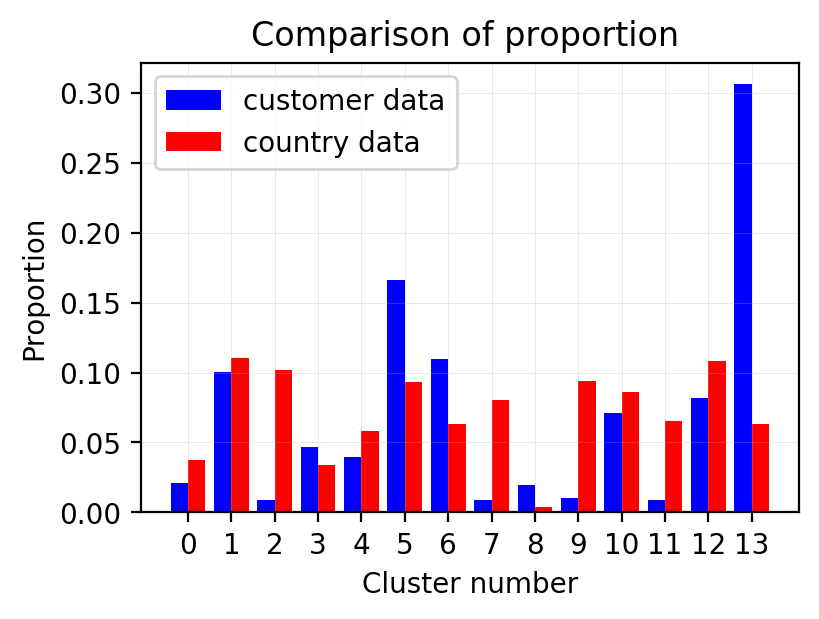

In [349]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.

array_density_customer, array_bins_used \
    = np.histogram(model_redict_customer_data, bins = np.linspace(-0.5, 13.5, 15), density = True)
array_density_country, array_bins_used \
    = np.histogram(model_redict_country_data, bins = np.linspace(-0.5, 13.5, 15), density= True)
plt.figure(figsize = (4,3), dpi = 200, facecolor = 'white')
plt.bar(np.linspace(-0.0, 13.0, 14) - 0.2, array_density_customer, width = 0.4, color = 'blue', label = 'customer data')
plt.bar(np.linspace(-0.0, 13.0, 14) + 0.2, array_density_country, width = 0.4, color = 'red', label = 'country data')
plt.xticks(range(0,14))
plt.title('Comparison of proportion ')
plt.tight_layout()
plt.grid(linewidth = 0.3, alpha = 0.3)
plt.legend(loc = 'upper left')
plt.xlabel('Cluster number')
plt.ylabel('Proportion')
plt.show()

Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the .inverse_transform() method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.

In [433]:
temp_center_data = pca.inverse_transform(k_means_model.cluster_centers_[13])
temp_inv_scaled_center_data = scaler.inverse_transform(temp_center_data).round()

list_name = list(dict_weights)[:5] + list(dict_weights)[-5:]
list_used_index = []
for col_name in list_name:
    dict_weights[col_name]
    list_used_index.append(np.where(dataframe_azdias_lower.columns == col_name)[0][0])

for i_index_tesmp in range(len(list_name)):
    print('Standard value of {}'.format(list_name[i_index_tesmp]).ljust(60), end = '')
    print('is ', int(temp_inv_scaled_center_data[list_used_index[i_index_tesmp]]))


Standard value of ALTERSKATEGORIE_GROB                      is  3
Standard value of FINANZ_VORSORGER                          is  4
Standard value of SEMIO_ERL                                 is  4
Standard value of SEMIO_LUST                                is  5
Standard value of RETOURTYP_BK_S                            is  4
Standard value of SEMIO_PFLICHT                             is  3
Standard value of SEMIO_TRADV                               is  3
Standard value of FINANZ_SPARER                             is  1
Standard value of PRAEGENDE_JUGENDJAHRE_decade              is  2
Standard value of SEMIO_REL                                 is  4


In [379]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?
print('The over represnted cluster is number 13')
array_index = np.where(model_redict_customer_data==13)
customer_inverse = pca.inverse_transform(customers_cleaned_pca[array_index])

data_customer = scaler.inverse_transform(customer_inverse).round()
dataframe_customer_reverse_over = pd.DataFrame(data=data_customer,
          index=np.array(range(0, data_customer.shape[0])),
          columns=dataframe_azdias_lower.columns)

array_index = np.where(model_redict_country_data==13)
country_inverse = pca.inverse_transform(dataframe_azdias_lower_pca[array_index])

data_country = scaler.inverse_transform(country_inverse).round()
dataframe_country_reverse_over = pd.DataFrame(data=data_country,
          index=np.array(range(0, data_country.shape[0])),
          columns=dataframe_azdias_lower.columns)



The over represnted cluster is number 13


In [453]:
def function_compare_dist_with_name(
        dataframe_data_1, 
        str_name_1,
        dataframe_data_2, 
        str_name_2,
        str_name_col,
        str_super_tile):
    plt.figure(figsize= (8,3), dpi =400, facecolor = 'white')
    plt.subplot(121)
    plt.title(str_name_1)
    sns.countplot(data=dataframe_data_1, x=str_name_col)
    plt.subplot(122)
    plt.title(str_name_2)
    sns.countplot(data=dataframe_data_2, x=str_name_col)
    plt.suptitle(str_super_tile)
    plt.tight_layout()
    plt.show()



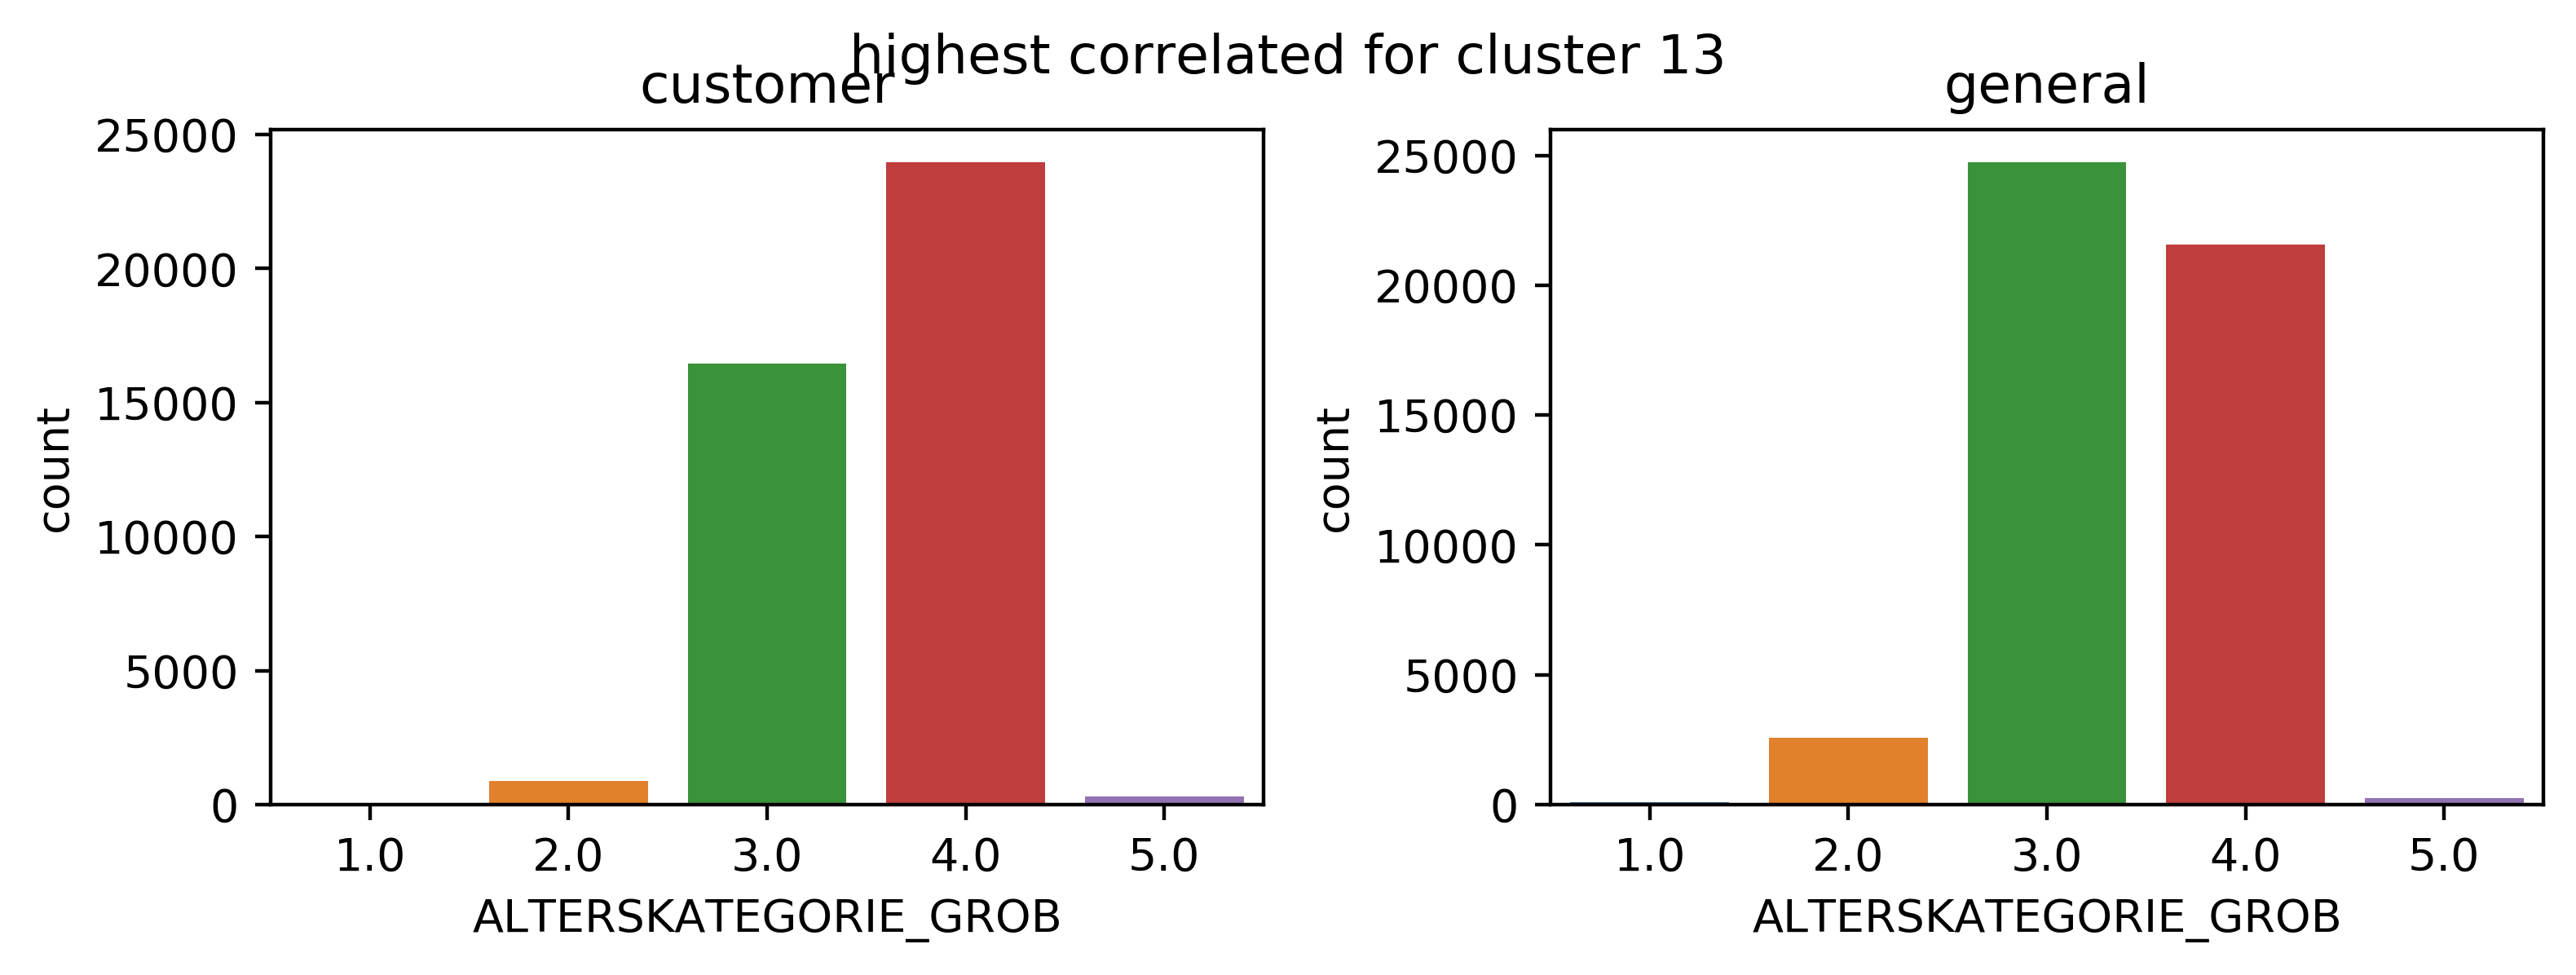

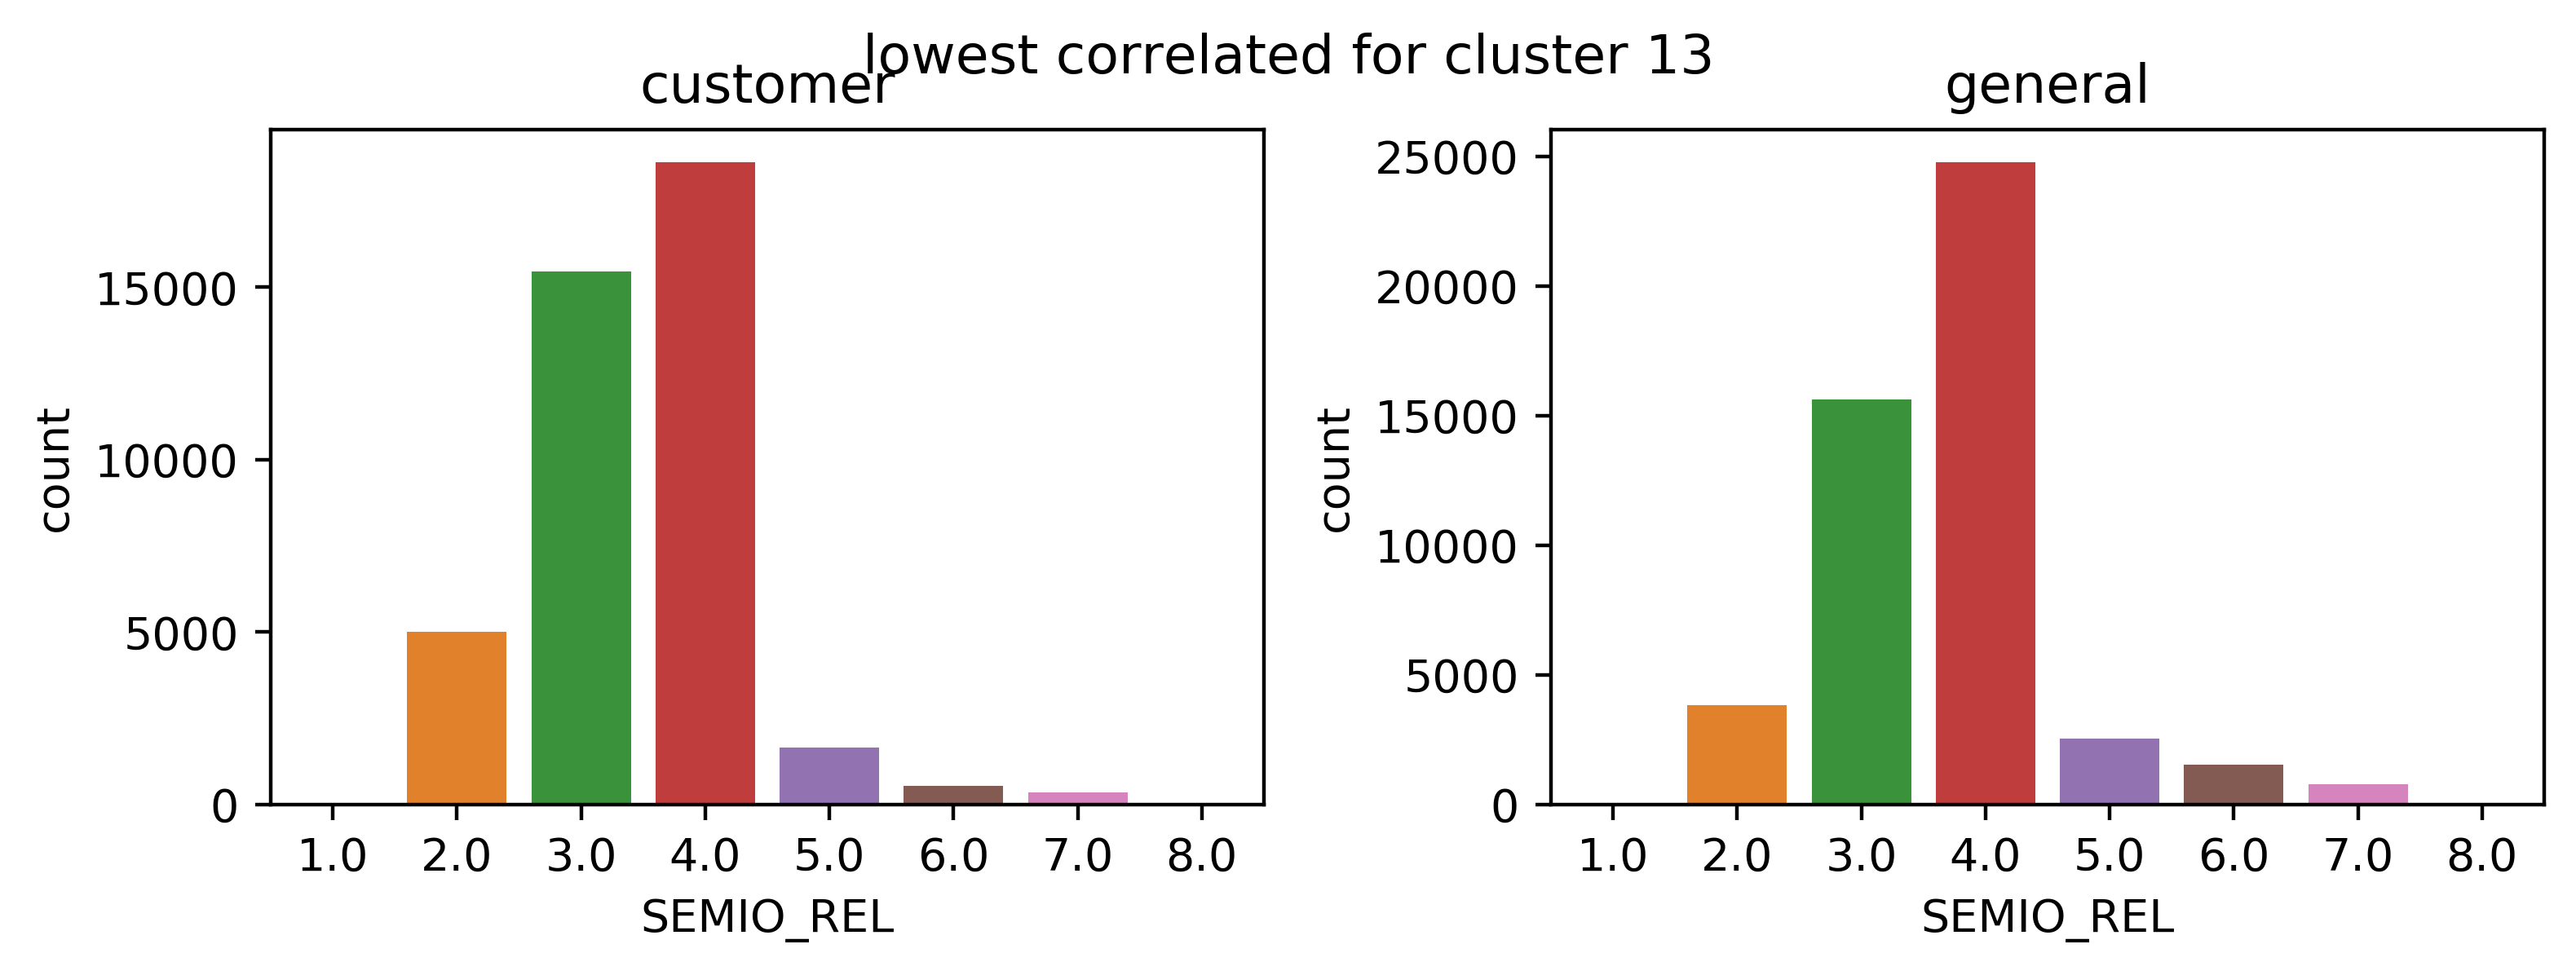

In [454]:
function_compare_dist_with_name(
    dataframe_customer_reverse_over[list_name],
    'customer',
    dataframe_country_reverse_over[list_name],
    'general',
    list_name[0], 
    'highest correlated for cluster 13')
function_compare_dist_with_name(
    dataframe_customer_reverse_over[list_name],
    'customer',
    dataframe_country_reverse_over[list_name],
    'general',
    list_name[-1], 
    'lowest correlated for cluster 13')

In [435]:
dataframe_country_reverse_over[list_name]

ALTERSKATEGORIE_GROB  FINANZ_VORSORGER  SEMIO_ERL  SEMIO_LUST  \
0                       3.0               3.0        4.0         6.0   
1                       3.0               3.0        4.0         6.0   
2                       3.0               4.0        3.0         2.0   
3                       3.0               3.0        5.0         4.0   
4                       3.0               2.0        4.0         4.0   
...                     ...               ...        ...         ...   
49188                   3.0               4.0        5.0         6.0   
49189                   3.0               5.0        3.0         6.0   
49190                   3.0               5.0        4.0         6.0   
49191                   3.0               5.0        4.0         4.0   
49192                   3.0               5.0        3.0         3.0   

       RETOURTYP_BK_S  SEMIO_PFLICHT  SEMIO_TRADV  FINANZ_SPARER  \
0                 4.0            3.0          2.0            3.0   
1                 5.0            4.0          3.0            2.0   
2                 5.0            4.0          3.0            3.0   
3                 4.0            3.0          4.0            2.0   
4                 3.0            4.0          4.0            4.0   
...               ...            ...          ...            ...   
49188             5.0            4.0          2.0            2.0   
49189             3.0            3.0          3.0            1.0   
49190             5.0            3.0          4.0            1.0   
49191             3.0            3.0          5.0            1.0   
49192             5.0            3.0          2.0            1.0   

       PRAEGENDE_JUGENDJAHRE_decade  SEMIO_REL  
0                               4.0        3.0  
1                               3.0        4.0  
2                               4.0        4.0  
3                               3.0        4.0  
4                               5.0        4.0  
...                             ...        ...  
49188                           3.0        4.0  
49189                           2.0        4.0  
49190                           2.0        4.0  
49191                           2.0        4.0  
49192                           2.0        3.0  

[49193 rows x 10 columns]

In [436]:
# What kinds of people are part of a cluster that is underrepresented in thea
# customer data compared to the general population?

print('The underrepresnted cluster is number 2')
array_index = np.where(model_redict_customer_data==2)
customer_inverse = pca.inverse_transform(customers_cleaned_pca[array_index])

data_customer = scaler.inverse_transform(customer_inverse).round()
dataframe_customer_reverse_under = pd.DataFrame(data=data_customer,
          index=np.array(range(0, data_customer.shape[0])),
          columns=dataframe_azdias_lower.columns)

array_index = np.where(model_redict_country_data==2)
country_inverse = pca.inverse_transform(dataframe_azdias_lower_pca[array_index])

data_country = scaler.inverse_transform(country_inverse).round()
dataframe_country_reverse_under = pd.DataFrame(data=data_country,
          index=np.array(range(0, data_country.shape[0])),
          columns=dataframe_azdias_lower.columns)



The underrepresnted cluster is number 2


In [437]:
dataframe_customer_reverse_under[list_name]

ALTERSKATEGORIE_GROB  FINANZ_VORSORGER  SEMIO_ERL  SEMIO_LUST  \
0                      2.0               3.0        4.0         1.0   
1                      3.0               2.0        6.0         6.0   
2                      3.0               2.0        6.0         6.0   
3                      2.0               2.0        4.0         2.0   
4                      1.0               3.0        4.0         1.0   
...                    ...               ...        ...         ...   
1190                   1.0               2.0        4.0         3.0   
1191                   4.0               2.0        6.0         5.0   
1192                   2.0               3.0        5.0         3.0   
1193                   2.0               4.0        5.0         6.0   
1194                   1.0               6.0        3.0         2.0   

      RETOURTYP_BK_S  SEMIO_PFLICHT  SEMIO_TRADV  FINANZ_SPARER  \
0                3.0            5.0          6.0            3.0   
1                1.0            4.0          3.0            5.0   
2                5.0            4.0          2.0            5.0   
3                3.0            6.0          6.0            4.0   
4                2.0            6.0          6.0            4.0   
...              ...            ...          ...            ...   
1190             2.0            6.0          7.0            4.0   
1191             2.0            2.0          2.0            5.0   
1192             2.0            6.0          7.0            3.0   
1193             4.0            7.0          6.0            3.0   
1194             5.0            7.0          6.0            1.0   

      PRAEGENDE_JUGENDJAHRE_decade  SEMIO_REL  
0                              4.0        4.0  
1                              5.0        3.0  
2                              5.0        3.0  
3                              5.0        4.0  
4                              5.0        4.0  
...                            ...        ...  
1190                           5.0        6.0  
1191                           5.0        2.0  
1192                           4.0        5.0  
1193                           3.0        7.0  
1194                           1.0        6.0  

[1195 rows x 10 columns]

In [438]:
dataframe_country_reverse_under[list_name]

ALTERSKATEGORIE_GROB  FINANZ_VORSORGER  SEMIO_ERL  SEMIO_LUST  \
0                       1.0               2.0        3.0         2.0   
1                       2.0               2.0        5.0         1.0   
2                       2.0               4.0        5.0         3.0   
3                       2.0               3.0        4.0         2.0   
4                       1.0               3.0        2.0         2.0   
...                     ...               ...        ...         ...   
78718                   1.0               2.0        3.0         0.0   
78719                   2.0               2.0        4.0         2.0   
78720                   2.0               3.0        4.0         2.0   
78721                   1.0               2.0        4.0         1.0   
78722                   2.0               2.0        5.0         5.0   

       RETOURTYP_BK_S  SEMIO_PFLICHT  SEMIO_TRADV  FINANZ_SPARER  \
0                 1.0            7.0          6.0            5.0   
1                 1.0            6.0          7.0            4.0   
2                 3.0            5.0          6.0            2.0   
3                 2.0            6.0          5.0            4.0   
4                 1.0            7.0          6.0            4.0   
...               ...            ...          ...            ...   
78718             2.0            7.0          6.0            5.0   
78719             2.0            5.0          6.0            4.0   
78720             3.0            6.0          5.0            4.0   
78721             4.0            5.0          6.0            4.0   
78722             1.0            6.0          6.0            5.0   

       PRAEGENDE_JUGENDJAHRE_decade  SEMIO_REL  
0                               5.0        5.0  
1                               5.0        5.0  
2                               3.0        4.0  
3                               5.0        5.0  
4                               5.0        6.0  
...                             ...        ...  
78718                           5.0        6.0  
78719                           5.0        4.0  
78720                           5.0        5.0  
78721                           5.0        4.0  
78722                           5.0        5.0  

[78723 rows x 10 columns]

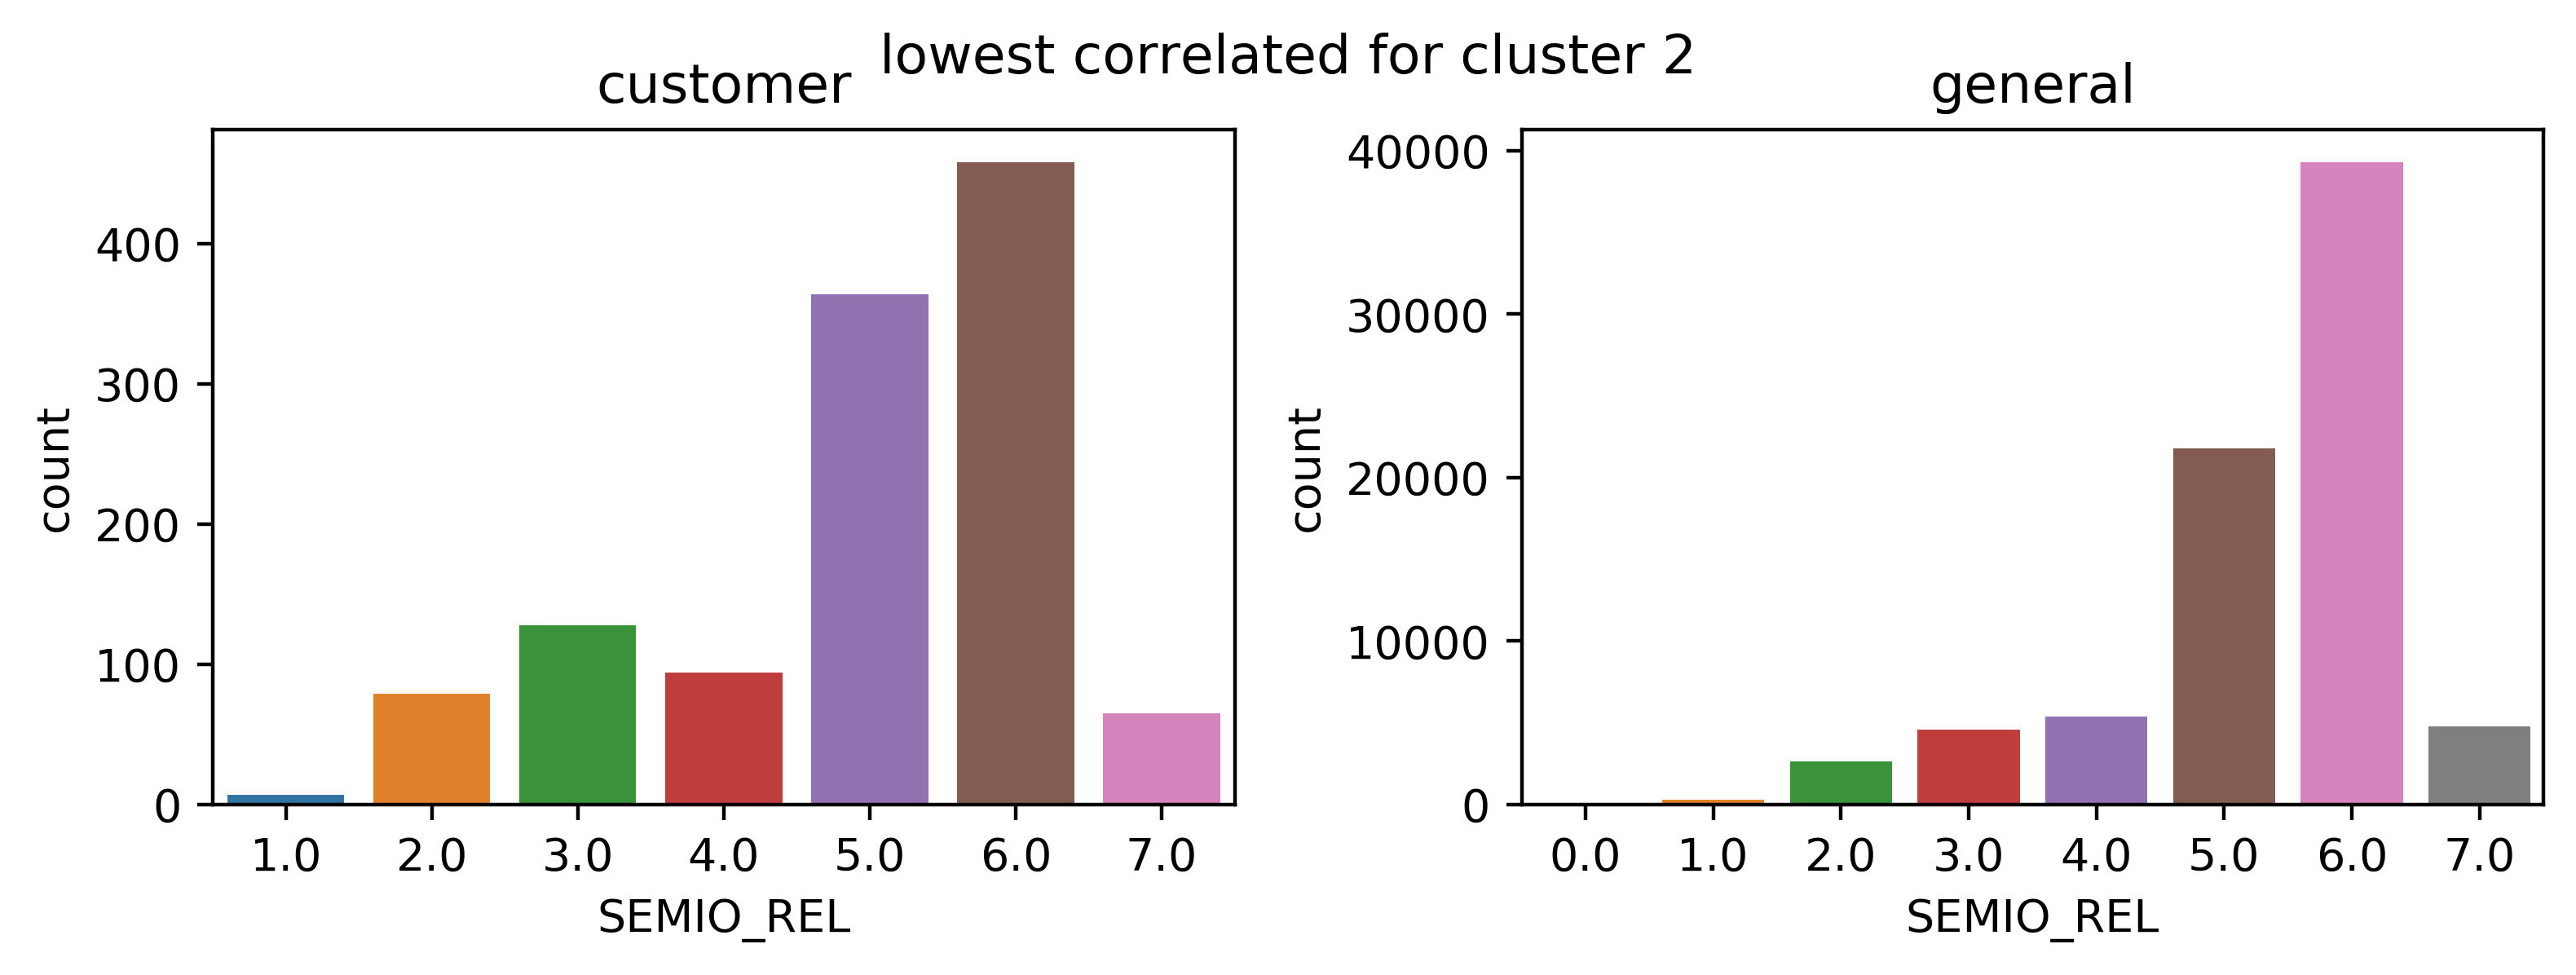

In [456]:
function_compare_dist_with_name(
    dataframe_customer_reverse_under[list_name],
    'customer',
    dataframe_country_reverse_under[list_name],
    'general',
    list_name[0], 
    'highest correlated for cluster 2')
function_compare_dist_with_name(
    dataframe_customer_reverse_under[list_name],
    'customer',
    dataframe_country_reverse_under[list_name],
    'general',
    list_name[-1], 
    'lowest correlated for cluster 2')

#### Discussion about the overrepresentation and underrepresentation
<span style = "color:blue">

- Overrepresentation  cluster 13

- Underrepresentation cluster 2

The distribution of overrepresentation and underrepresentation clusters are compared. It is observed that the distributions are different for the most effective features. This is the reason that leads to over and under representations. 
This observation will help design the target customer characteristics and help better advertisement delivery
</span>

### Discussion 3.3: Compare Customer Data to Demographics Data

(Double-click this cell and replace this text with your own text, reporting findings and conclusions from the clustering analysis. Can we describe segments of the population that are relatively popular with the mail-order company, or relatively unpopular with the company?)

<span style = "color:blue">
    
Clusters 5 and 13 are the most popular with the company. 
While the customer data and the country data are different in distirbutions, 
the resulte is reasonable since the customer should be only a portion of the general population of a country.

Focusing on the difference betwenn the general population and the customer,
we can get the conclusion that the advertisements should be moree focused 
on cluster 13 and less focused on cluster 2.

With more time and more computational resources, more analysis can be conducted.
</span>

> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.